# Gaussian Processes for Regression

<p style="text-align: justify; overflow-x:hidden;">Hello, and welcome to the notebook for Gaussian Processes for Regression, which is part of the assignment for the course CEGM2003. In this notebook, 1-dimensional data are fit with a stochastic process. Firstly, the data are visualised and inspected. Secondly, different kernels are specified and visualised, together with their prior distributions. Thirdly, with the help of an optimiser, the model parameters are optimised for the best fit posterior distribution. Finally, to quantify how well the model generalises, the model is tested on unseen data. The results are then compared to results obtained during Kriging, which used the same dataset. Please see the <a href="https://surfdrive.surf.nl/files/index.php/s/HVIy8Y2Yg6mLorB/download?path=%2F&files=GEOSPATIAL__Exploring%20the%20effect%20of%20different%20formulations%20of%20Gaussian%20processes%20on%20spatial%20predictions.pdf">Full Project Description</a>, for more detail. In short, the goal is to fit the data with a Gaussian process. The Gaussian process is described by a kernel. A variety of different kernels will be tested, to find the best performing kernel, i.e. the kernel that makes the Gaussian process closest to the observed data. With hyperparameter optimization, the aim is to find the set of hyperparameters that result in the model achieving the smallest loss (or highest performance) on the validation or test dataset. The best performing kernel, with the lowest validation loss, is then selected and used for testing the model.<br>
<b>Note to the reader:</b> both the kernel parameters as well as the type of kernel are considered hyperparameters (as Gaussian processes are non-parammetric models by default), however, in this assignment the type of kernel is the primary focus.</p>

<div style="overflow-x: hidden;"><p style="text-align: justify;">Gaussian processes are stochastic processes that describe systems that randomly change over time. Systems or data with a certain level of uncertainty are considered stochastic. In this assignment, realisations of a function are sampled from a stochastic process. Due to the randomness of the stochastic process, each realisation is different. Gaussian processes are defined as distributions over functions <math display='inline'>y(x)</math>. The distributions are defined by a mean function <math display='inline'>m(x)</math> and a positive definite symmetric covariance function <math dispay='inline'>k(x, x')</math> (kernel), with <math display="inline">x</math> the function values and <math display="inline">(x, x')</math> all possible pairs in the input domain:</p><div>

$$$
y(x) \sim \mathcal{GP}(m(x),k(x,x')), \text{with } k(x, x') = \frac{1}{\alpha}\phi(x)^T\phi(x') 
$$$

<p style="text-align: justify; overflow-x:hidden;">For an finite subset <math display='inline'>X = {x<sub>1</sub>...x<sub>n</sub>}</math> of the domain of <math display='inline'>x</math>. The marginal distribution is a multivariate Gaussian:</p>

$$$
y(X) \sim \mathcal{N}(m(X),k(X,X'))
$$$

<p style="text-align: justify; overflow-x:hidden;">The covariance function <math display='inline'>k</math> models the joint variability of the Gaussian proces random variables. It returns the modelled covariance between each pair. To sample functions from the marginal distriubtion, a mean and covariance need to be defined. The covariance function is also known as a kernel, that implies a distriubtion over functions <math display='inline'>y(x)</math>. More information about kernels can be found later in the notebook.</p> 

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

# Import all the required libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
import copy

from cycler import cycler

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.model_selection import KFold
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import *
from prettytable import PrettyTable
from sklearn.metrics import *
from tqdm import tqdm

from helper_functions import *

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

# Set a fixed seed, needed for reproduction of the results 
seed = 1
np.random.seed(seed)

# Loading and Preparing Data

<p style="text-align: justify; overflow-x:hidden;">The <a href="https://www.sciencebase.gov/catalog/item/5fbbf574d34eb413d5e2553a">data</a> is a set of contaminated sites of boreholes in the United States and links to this <a href="https://doi.org/10.1111/gwat.13081">paper</a>. This exercise uses only data from borehole <b>94-BR</b>, and the goal is to predict the <a href="https://www.dcceew.gov.au/environment/protection/npi/substances/fact-sheets/total-volatile-organic-compounds">Total Volatile Organic Compounds</a> (TVOC) [-] from depth [m]. There is a high likelihood that the data contains outliers. Instead of directly accounting for the outliers (e.g. Z-score method, Interquartile Range method), outliers are eliminated by sampling. Before sampling, data can contain clusters. Within clusters, data points can have a high correlation with each other. Some of these data points can be an outlier, disturbing the correlation between data points. Sampled data have a reduced number of clusters, thus a smaller chance that outliers skew the covariance matrix (containing the correlation between pairs of data points). To account for potential outliers in the data that are still present after sampling, the TVOC is log-normalised. The initial dataset has been partitioned into training, validation, and test sets with a distribution of 70% for training, 15% for validation, and 15% for testing.</p>

In [2]:
# Read the data from the provided csv file
df_sites = pd.read_csv('contaminated-sites_dataset.csv', sep=',', header=0)

# Select well
df_sites = df_sites.loc[df_sites['WELL_ID'] == '94-BR']

# Make a deep copy, so that we do not loose the orginal dataframe
df = copy.deepcopy(df_sites)

# Prepare the data by selecting the right columns, getting rid of NaN values and normalizing
df = df[['TVOC', 'DEPTH']]
df = df.dropna()

# Sample the TVOC value for each meter in the dataset to potentially have less outliers in the data
df = df[round(df['DEPTH'] % .3, 2) == 0.02]

# Log transform the TVOC data
df['TVOCLog'] = np.log(df['TVOC'])

# Prepare data to be split in train, validation, and test dataset (no dataframes)
X = df['DEPTH'].values.reshape(-1, 1)
y = df['TVOCLog'].values

# Split the data into train (70%) and temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=seed)

# Split the temp DataFrame into validation (50%) and test (50%)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=seed)

# Sort the datasets based on depth (sampling happens randomly, that is why the depths are not in order)
train_df.sort_values(by='DEPTH', inplace=True)
validation_df.sort_values(by='DEPTH', inplace=True)
test_df.sort_values(by='DEPTH', inplace=True)

# Use sorted DataFrames to create the desired variables
X_train, X_temp, y_train, y_temp = train_df['DEPTH'].values.reshape(-1, 1), validation_df['DEPTH'].values.reshape(-1, 1), train_df['TVOCLog'].values, validation_df['TVOCLog'].values
X_val, X_test, y_val, y_test = validation_df['DEPTH'].values.reshape(-1, 1), test_df['DEPTH'].values.reshape(-1, 1), validation_df['TVOCLog'].values, test_df['TVOCLog'].values

# Descriptive Statistics and Data Visualization

In [3]:
print(f'Length Datasets: train; {len(train_df)}, validation; {len(validation_df)}, test; {len(test_df)}')

Length Datasets: train; 263, validation; 56, test; 57


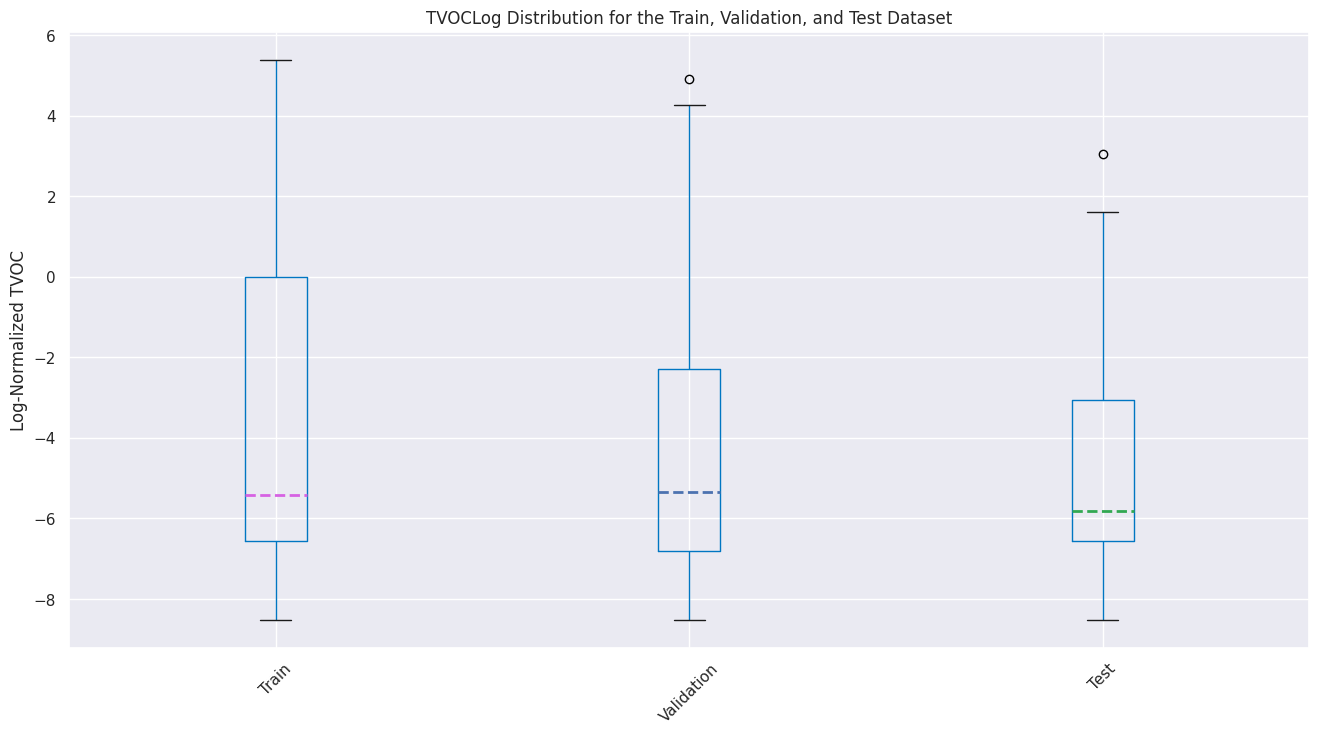

In [4]:
colors = ['#d662e3', 'b', '#32a852']

tvoc_df = pd.DataFrame({
    'Train': train_df['TVOCLog'],
    'Validation': validation_df['TVOCLog'],
    'Test': test_df['TVOCLog']
})

# Plot overlaid histograms for each column
fig, ax = plt.subplots(figsize=(16, 8))
for i, column in enumerate(tvoc_df.columns):
    median_properties = {
        'color': colors[i],
        'linestyle': '--',
        'linewidth': 2
    }
    tvoc_df.boxplot(column=column, positions=[i + 1], ax=ax, medianprops=median_properties)
    
plt.ylabel('Log-Normalized TVOC')
plt.xticks(range(1, 4), ['Train', 'Validation', 'Test'], rotation=45)
plt.title('TVOCLog Distribution for the Train, Validation, and Test Dataset');

<p style="text-align: justify; overflow-x:hidden;"><b>Observation:</b> From the plot above, it can be concluded that the three datasets (train, validation, and test) have log-normalised TVOC values that are consistent with each other. It is important to have log-normalised TVOC values that are in a similar range so that the model generalise patternes to unseen data. The patterns are consistent in all three datasets. Having consistent values across the datasets also helps with optimizing the hyperparameters in the validation step.</p>

## Data Distribution Visualization

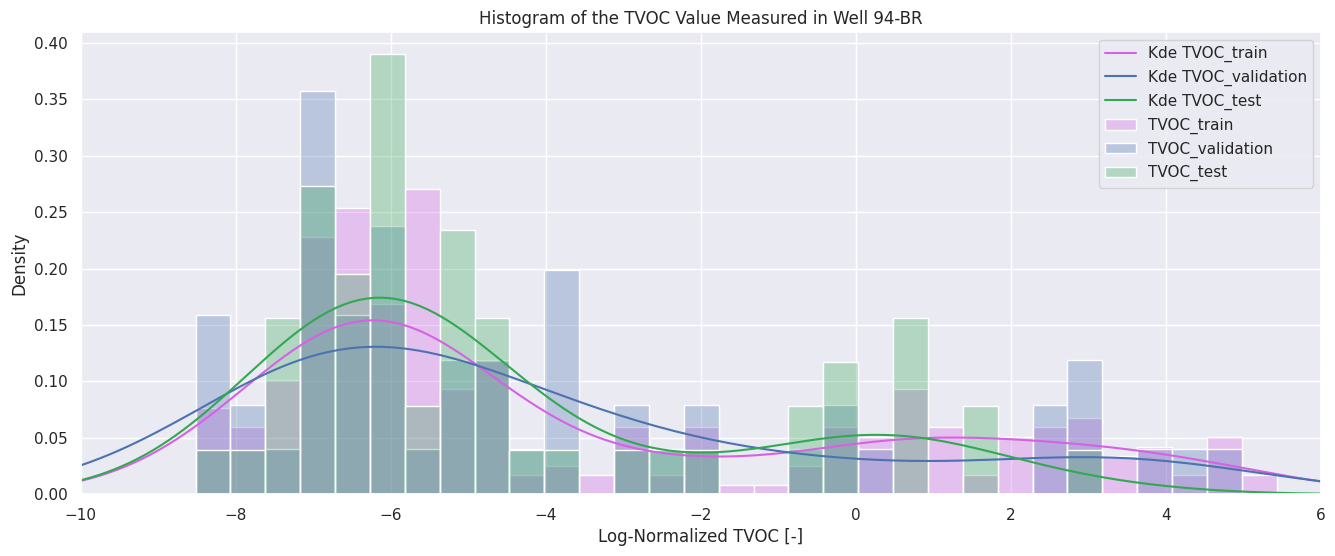

In [5]:
# Plot a histogram for the TVOC value in the train, validation, and test dataset

tvoc_dfs = [train_df[['TVOCLog']], validation_df[['TVOCLog']], test_df[['TVOCLog']]]
column_dfs = ['TVOC_train', 'TVOC_validation', 'TVOC_test']

# Concatenate DataFrames along columns
result_df = pd.concat(tvoc_dfs, axis=1, keys=column_dfs)


# Plot overlaid histograms for each column
plt.figure(figsize=(16, 6))

for i, column_df in enumerate(column_dfs):
    ax = sns.histplot(data=result_df[column_df], x="TVOCLog", label=column_df, alpha=0.3,
                      binwidth=0.45, kde=False, stat='density', color=colors[i])

    sns.kdeplot(data=result_df[column_df], x="TVOCLog", color=colors[i], ax=ax, label=f'Kde {column_df}')

plt.title('Histogram of the TVOC Value Measured in Well 94-BR')
plt.xlabel('Log-Normalized TVOC [-]')
plt.ylabel('Density')
plt.xlim(-10, 6)
plt.legend()
plt.show();

<p style="text-align: justify; overflow-x:hidden;"><b>Observation:</b> In the plot above, the log-normalised TVOC histogram is right-skewed, i.e. small TVOC values dominate the dataset. As the trainings dataset contains more data points, this logically results in higher counts of the TVOC values and thus a stronger skew.</p>

## Data Visualization 

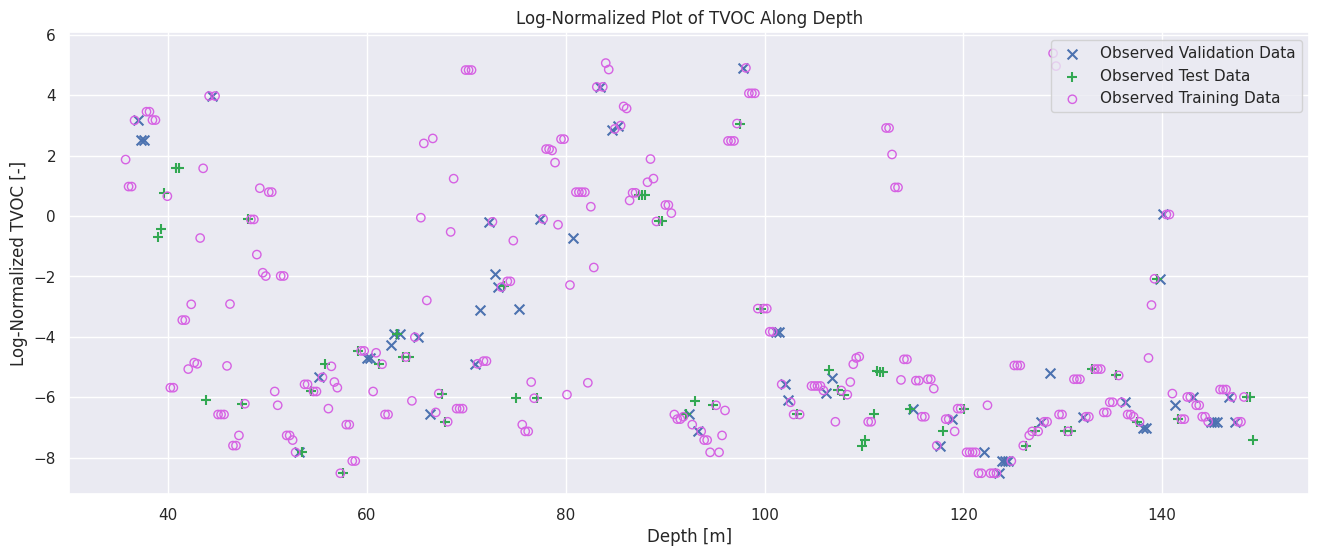

In [6]:
# Plot the TVOC value against the depth for the train, validation, and test dataset
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

depth_dfs = [train_df, validation_df, test_df]

# Due to the partitioning of the inital dataset, the data points in the separate datasets are no longer
# in the right order (of depth). Therefore the dataframe is sorted based on depth.
df.sort_values(by='DEPTH', inplace=True)

markers = ['o', 'x', '+']
type_data = ['Training', 'Validation', 'Test']

for i, depth_df in enumerate(depth_dfs):
    if type_data[i] == 'Training':
        continue
    ax.scatter(depth_df['DEPTH'], depth_df['TVOCLog'], marker=markers[i], s=50, label=f'Observed {type_data[i]} Data', color=colors[i])

ax.scatter(train_df['DEPTH'], train_df['TVOCLog'], facecolors='none', edgecolors='#d662e3', marker='o', label="Observed Training Data")

ax.set_title('Log-Normalized Plot of TVOC Along Depth')
ax.set_ylabel('Log-Normalized TVOC [-]')
ax.set_xlabel('Depth [m]');
plt.legend();

<p style="text-align: justify; overflow-x:hidden;"><b>Observation:</b> In the plot above, not much can be said or concluded about the log-normalized TVOC against depth due to the lack of clear trends or discernible patterns.</p>

# Kernel Construction and Visualization

<p style="text-align: justify; overflow-x:hidden;">In this section, different kernels, as specified by the <a href="https://scikit-learn.org/stable/modules/gaussian_process.html">Scikit Learn documentation</a>, are implemented and plotted to enhance one’s comprehension of their shape and how they capture the correlation between different data points. Kernel engineering can be considered an independent craft. Given limited time and resources, the primary focus is the pre-specified kernels by Scikit Learn, and one hybrid kernel. A hybrid kernel comprises multiple other kernels that simultaneously capture various patterns in the data. To account for noise, that is inherent to the data, every kernel is a combination of itself with the white noise kernel. To better understand how the kernels behave on the data and capture patterns in the data, the white noise kernel is turned off for the visualisations below. In the computations later in this notebook, the white noise kernel is added to each of the other kernels to account for the noise. The goal is to find the best performing kernel for the Gaussian process.</p>

## Definition of Different Kernels

In [7]:
# Kernels taken from Scikit Learn Documentation

# To the reader: instead of having the function below, one could also set a parameter to one of the kernels,
# and set the parameters of the specific kernel with: set_params(**params), as documented by scikit.

# Constant Kernel
def constant_kernel(hyperparams):
    """
    Creates a Constant Kernel for Gaussian Processes.

    Parameters:
    - hyperparams (dict): Dictionary containing hyperparameters.
        - constant_value (float): Constant value for the kernel.

    Returns:
    - ConstantKernel: Constant Kernel instance.
    """

    c_value = hyperparams['constant_value']
    return ConstantKernel(constant_value=c_value) 


# Radial Basis Function (RBF) Kernel
def rbf_kernel(hyperparams, length_scale=None):
    """
    Creates an RBF (Squared-Exponential) Kernel for Gaussian Processes.

    Parameters:
    - hyperparams (dict): Dictionary containing hyperparameters.
        - length_scale (float): Length scale parameter.

    Returns:
    - RBF: RBF Kernel instance.
    """

    length = length_scale if length_scale is not None else hyperparams['length_scale']
    return RBF(length) 


# Matern Kernel
def matern_kernel(hyperparams, length_scale=None, nu=None):
    """
    Creates a Matern Kernel for Gaussian Processes.

    Parameters:
    - hyperparams (dict): Dictionary containing hyperparameters.
        - length_scale (float): Length scale parameter.
        - nu (float): Additional smoothness parameter.

    Returns:
    - Matern: Matern Kernel instance.
    """

    length = length_scale if length_scale is not None else hyperparams['length_scale']
    nu = nu if nu is not None else hyperparams['nu']
    return Matern(length_scale=length, nu=nu) 


# Rational Quadratic Kernel
def rq_kernel(hyperparams, length_scale=None, alpha=None):
    """
    Creates a Rational Quadratic Kernel for Gaussian Processes.

    Parameters:
    - hyperparams (dict): Dictionary containing hyperparameters.
        - length_scale_RQ (float): Length scale parameter for RQ.
        - alpha (float): Scale mixture parameter.

    Returns:
    - RationalQuadratic: Rational Quadratic Kernel instance.
    """

    length = length_scale if length_scale is not None else hyperparams['length_scale_RQ']
    alpha = alpha if alpha is not None else hyperparams['alpha']
    return RationalQuadratic(length_scale=length, alpha=alpha) 


# Exp-Sine-Squared Kernel
def expSineSQ_kernel(hyperparams, length_scale=None, period=None):
    """
    Creates an Exp-Sine-Squared (Periodic) Kernel for Gaussian Processes.

    Parameters:
    - hyperparams (dict): Dictionary containing hyperparameters.
        - length_scale_ESSQ (float): Length scale parameter.
        - period (float): Periodicity parameter.

    Returns:
    - ExpSineSquared: Exp-Sine-Squared Kernel instance.
    """

    length = length_scale if length_scale is not None else hyperparams['length_scale_ESSQ']
    period = period if period is not None else hyperparams['period']
    return ExpSineSquared(length_scale=length, periodicity=period) 


# Dot-Product Kernel
def dotProduct_kernel(hyperparams):
    """
    Creates a Dot-Product Kernel for Gaussian Processes.

    Returns:
    - DotProduct: Dot-Product Kernel instance.
    """

    return DotProduct() 


# White Kernel
def white_kernel(noise_level=None):
    """
    Creates a White Kernel for Gaussian Processes.

    Parameters:
    - noise_level (float): Noise level parameter.

    Returns:
    - WhiteKernel: White Kernel instance.
    """

    return WhiteKernel(noise_level)


# Hybrid Kernel
def hybrid_kernel(hyperparams):
    """
    Creates a Hybrid Kernel consisting of Dot Product, Matern, and Constant Kernels for Gaussian Processes.

    Parameters:
    - hyperparams (dict): Dictionary containing hyperparameters.

    Returns:
    - SumKernel: Sum of Kernels (Dot Product + Matern + Constant) instance.
    """

    return dotProduct_kernel(hyperparams) + matern_kernel(hyperparams) + constant_kernel(hyperparams)

## Parameter Initialization

In [8]:
# Some initialization parameters for the kernels
hyperparameters = {
    'constant_value': 1.0,
    'length_scale': 1.0,
    'nu': 1.5,
    'length_scale_RQ': 1.0,
    'alpha': 1.0,
    'length_scale_ESSQ': 1.0,
    'period': 2.0,
}

white_kernel_state = False 

## Kernel Visualizations

In [9]:
def plot_axes(ax, cov, ktype, xlim, X, description):
    """
    Plot the covariance matrix.

    Parameters:
    - ax (matplotlib.axes._axes.Axes): Matplotlib axes object for the plot.
    - cov (numpy.ndarray): Covariance matrix to be plotted.
    - ktype (str): Type of kernel used.
    - xlim (tuple): Tuple representing the x-axis limits.
    - X (numpy.ndarray): Input data points.
    - description (str): Description of the plot.

    Returns:
    - None

    This function plots the covariance matrix using a heatmap, sets axis labels, and adds custom ticks.
    """

    im = ax.imshow(cov)
    cbar = plt.colorbar(im, ax=ax, fraction=0.045, pad=0.02)
    cbar.ax.set_ylabel("$K(X,X)$", fontsize=10)
    ax.set_title((f"{ktype}\n{description}"))
    ax.set_xlabel("X", fontsize=10, labelpad=0)
    ax.set_ylabel("X", fontsize=10, labelpad=0)
    
    # Show 5 custom ticks on x an y axis of covariance plot
    nb_ticks = 5
    ticks = list(range(xlim[0], xlim[1] + 1))
    ticks_idx = np.rint(np.linspace(
        1, len(ticks), num=min(nb_ticks, len(ticks))) - 1).astype(int)
    ticks = list(np.array(ticks)[ticks_idx])
    ax.set_xticks(np.linspace(0, len(X), len(ticks)))
    ax.set_yticks(np.linspace(0, len(X), len(ticks)))
    ax.set_xticklabels(ticks)
    ax.set_yticklabels(ticks)
    ax.grid(False)


def plot_covariance(kernels, kernel_type, settings, hyperparameters):
    """
    Plot covariance matrices for different kernels.

    Parameters:
    - kernels (list): List of kernel functions.
    - kernel_type (list): List of kernel types corresponding to each kernel.
    - settings (list): List of descriptions for each plot.
    - hyperparameters (dict): Dictionary containing hyperparameters for the kernels.

    Returns:
    - None

    This function generates subplots for covariance matrices based on different kernels and their settings.
    """

    fig, axs = plt.subplots(2, 3, figsize=(16, 8))
    xlim = (-2, 2)
    X = np.expand_dims(np.linspace(*xlim, 200), 1)

    for idx, (kernel_fn, ktype, setting) in enumerate(zip(kernels, kernel_type, settings)):

        # Check if the white noise kernel should be added to account for the noise or not
        if white_kernel_state:
            kernel = kernel_fn(hyperparameters) + white_kernel()
        else:
            kernel = kernel_fn(hyperparameters)

        cov = kernel(X)

        i, j = divmod(idx, 3)  # Calculate subplot indices

        plot_axes(axs[i, j], cov, ktype, xlim, X, description=setting)  # Use the correct subplot

    fig.suptitle('Covariance Matrices for Different Kernels', fontsize=16)
    plt.tight_layout()
    plt.show()

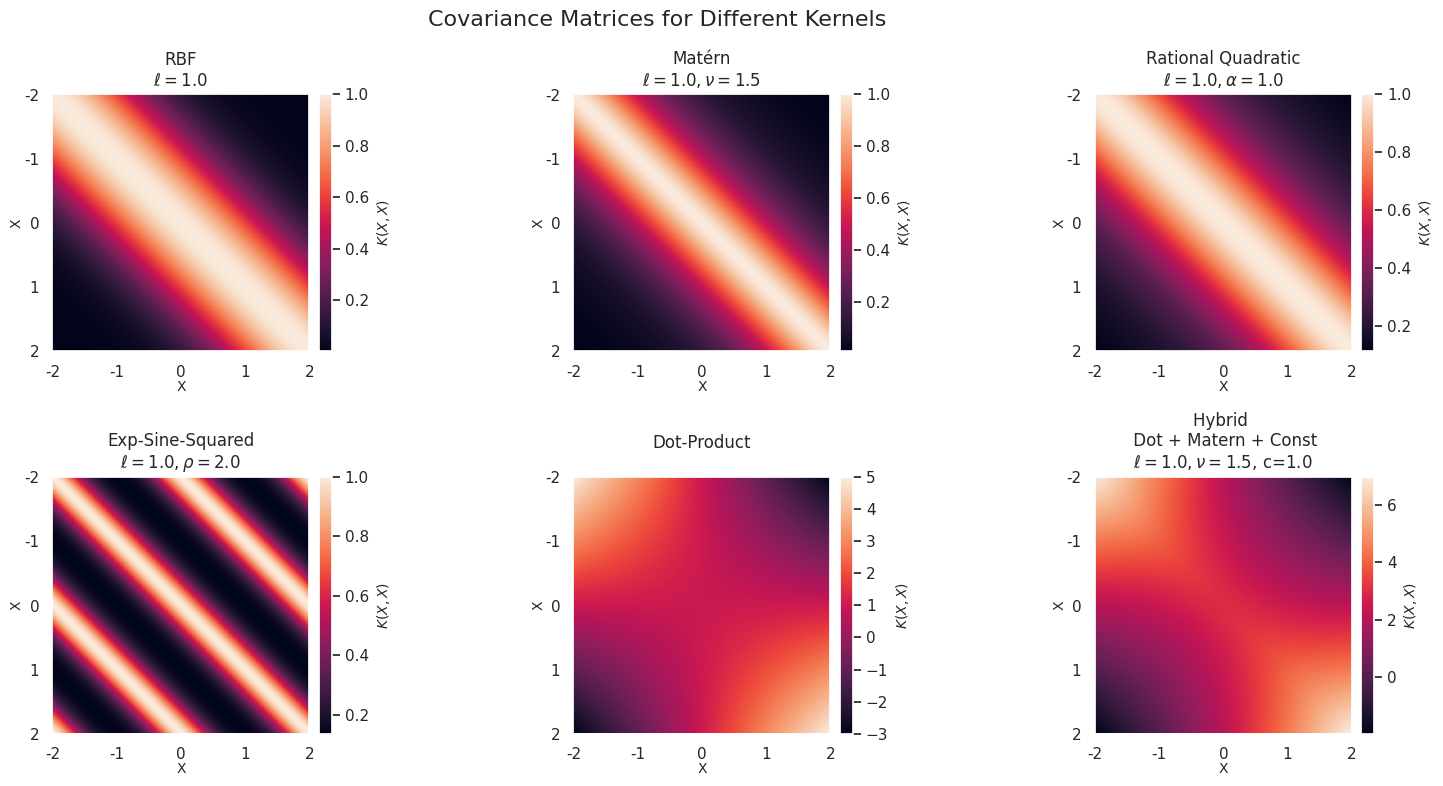

In [10]:
# Specify the kernels that are getting plotted including their name and settings (the white kernel is omitted here)

kernels = [
    rbf_kernel,
    matern_kernel,
    rq_kernel,
    expSineSQ_kernel,
    dotProduct_kernel,
    hybrid_kernel,
]
kernel_types = [
    'RBF',
    'Matérn',
    'Rational Quadratic',
    'Exp-Sine-Squared',
    'Dot-Product',
    'Hybrid \n Dot + Matern + Const',
]
settings = [
    f"$\\ell={hyperparameters['length_scale']}$",
    f"$\\ell={hyperparameters['length_scale']}, \\nu={hyperparameters['nu']}$",
    f"$\\ell={hyperparameters['length_scale_RQ']}, \\alpha={hyperparameters['alpha']}$",
    f"$\\ell={hyperparameters['length_scale_ESSQ']}, \\rho={hyperparameters['period']}$",
    "",
    f"$\\ell={hyperparameters['length_scale']}, \\nu={hyperparameters['nu']}$, c={hyperparameters['constant_value']}"
]

plot_covariance(kernels, kernel_types, settings, hyperparameters)

<p style="text-align: justify; overflow-x:hidden;"><b>Note:</b> Above, the covariances of the kernels (without the white noise kernel) are displayed. For a synthetic dataset, these plots provide insight into the correlation between different data points. The visualisation can help understand how the chosen kernel captures patterns and structures in the data. Diagonal elements represent the variance of individual data points. Higher values indicate larger variances. The off-diagonal elements represent the covariance between pairs of data points. Negative values suggest a negative correlation, whereas positive values suggest a positive correlation. Each kernel has its characteristics, defined by parameters such as length scale in a radial basis function (RBF) kernel. The length scale influences the smoothness of the function. Arbitrary initial parameters are defined, which will be optimized for later in this notebook.</p>

## Prior Distributions Visualizations

<p style="text-align: justify; overflow-x:hidden; overflow-y:hidden;">In the section below, different function realisations are sampled from a Gaussian process (with synthetic data), each with its unique kernel. The functions are characterised by the initialisation of the hyperparameters. The prior is considered jointly Gaussian, as any arbitrary number of points in the function being jointly Gaussian. The graph below represents the prior over <math display='inline'>y(x)</math>, with no observed data yet. From this graph, a general expression for the joint over two groups of function values <math><msub><mrow data-mjx-texclass="ORD"><mi mathvariant="bold">y</mi></mrow><mi>a</mi></msub></math> and <math><msub><mrow data-mjx-texclass="ORD"><mi mathvariant="bold">y</mi></mrow><mi>b</mi></msub></math>.</p> 

<div style="display: flex; justify-content: center; align-items: center;">
<img style="text-align: center;" src="/work/gpgraph3.jpg" alt="SVG Image" width="600" height="200">
</div>
<p style="display: flex; justify-content: center; align-items: center;">Graph representation of a GP prior, with <i>N</i> jointly Gaussian values of <math display='inline'>y(x)</math>.</p>

<div style="overflow-y: hidden; height: 10vh;">
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block" style="overflow-y: hidden; margin-top:25px;">
  <mtable displaystyle="true" columnalign="right" columnspacing="0em" rowspacing="3pt" style="overflow-y: hidden;">
    <mtr>
      <mtd >
        <mi>p</mi>
        <mo stretchy="false">(</mo>
        <msub>
          <mrow data-mjx-texclass="ORD">
            <mi mathvariant="bold">y</mi>
          </mrow>
          <mi>a</mi>
        </msub>
        <mo>,</mo>
        <mstyle>
          <msub>
            <mrow data-mjx-texclass="ORD">
              <mi mathvariant="bold">y</mi>
            </mrow>
            <mi>b</mi>
          </msub>
        </mstyle>
        <mo stretchy="false">)</mo>
        <mo>=</mo>
        <mrow data-mjx-texclass="ORD">
          <mi data-mjx-variant="-tex-calligraphic" mathvariant="script">N</mi>
        </mrow>
        <mrow data-mjx-texclass="INNER">
          <mo data-mjx-texclass="OPEN">(</mo>
          <mrow data-mjx-texclass="ORD">
            <mi mathvariant="bold">y</mi>
          </mrow>
          <mrow data-mjx-texclass="INNER">
            <mo data-mjx-texclass="OPEN">|</mo>
            <mo data-mjx-texclass="CLOSE" fence="true" stretchy="true" symmetric="true"></mo>
          </mrow>
          <mrow data-mjx-texclass="ORD">
            <mn mathvariant="bold">0</mn>
          </mrow>
          <mo>,</mo>
          <mrow data-mjx-texclass="INNER">
            <mo data-mjx-texclass="OPEN">[</mo>
            <mtable columnalign="center" columnspacing="1em" rowspacing="4pt">
              <mtr>
                <mtd>
                  <mi>K</mi>
                  <mrow data-mjx-texclass="INNER">
                    <mo data-mjx-texclass="OPEN">(</mo>
                    <msub>
                      <mrow data-mjx-texclass="ORD">
                        <mi mathvariant="bold">X</mi>
                      </mrow>
                      <mi>a</mi>
                    </msub>
                    <mo>,</mo>
                    <msub>
                      <mrow data-mjx-texclass="ORD">
                        <mi mathvariant="bold">X</mi>
                      </mrow>
                      <mi>a</mi>
                    </msub>
                    <mo data-mjx-texclass="CLOSE">)</mo>
                  </mrow>
                </mtd>
                <mtd>
                  <mstyle>
                    <mi>K</mi>
                    <mrow data-mjx-texclass="INNER">
                      <mo data-mjx-texclass="OPEN">(</mo>
                      <msub>
                        <mrow data-mjx-texclass="ORD">
                          <mi mathvariant="bold">X</mi>
                        </mrow>
                        <mi>a</mi>
                      </msub>
                      <mo>,</mo>
                      <msub>
                        <mrow data-mjx-texclass="ORD">
                          <mi mathvariant="bold">X</mi>
                        </mrow>
                        <mi>b</mi>
                      </msub>
                      <mo data-mjx-texclass="CLOSE">)</mo>
                    </mrow>
                  </mstyle>
                </mtd>
              </mtr>
              <mtr>
                <mtd>
                  <mstyle>
                    <mi>K</mi>
                    <mrow data-mjx-texclass="INNER">
                      <mo data-mjx-texclass="OPEN">(</mo>
                      <msub>
                        <mrow data-mjx-texclass="ORD">
                          <mi mathvariant="bold">X</mi>
                        </mrow>
                        <mi>b</mi>
                      </msub>
                      <mo>,</mo>
                      <msub>
                        <mrow data-mjx-texclass="ORD">
                          <mi mathvariant="bold">X</mi>
                        </mrow>
                        <mi>a</mi>
                      </msub>
                      <mo data-mjx-texclass="CLOSE">)</mo>
                    </mrow>
                  </mstyle>
                </mtd>
                <mtd>
                  <mstyle>
                    <mi>K</mi>
                    <mrow data-mjx-texclass="INNER">
                      <mo data-mjx-texclass="OPEN">(</mo>
                      <msub>
                        <mrow data-mjx-texclass="ORD">
                          <mi mathvariant="bold">X</mi>
                        </mrow>
                        <mi>b</mi>
                      </msub>
                      <mo>,</mo>
                      <msub>
                        <mrow data-mjx-texclass="ORD">
                          <mi mathvariant="bold">X</mi>
                        </mrow>
                        <mi>b</mi>
                      </msub>
                      <mo data-mjx-texclass="CLOSE">)</mo>
                    </mrow>
                  </mstyle>
                </mtd>
              </mtr>
            </mtable>
            <mo data-mjx-texclass="CLOSE">]</mo>
          </mrow>
          <mo data-mjx-texclass="CLOSE">)</mo>
        </mrow>
        <mo>&#x2261;</mo>
        <mrow data-mjx-texclass="ORD">
          <mi data-mjx-variant="-tex-calligraphic" mathvariant="script">N</mi>
        </mrow>
        <mrow data-mjx-texclass="INNER">
          <mo data-mjx-texclass="OPEN">(</mo>
          <mrow data-mjx-texclass="ORD">
            <mi mathvariant="bold">y</mi>
          </mrow>
          <mrow data-mjx-texclass="INNER">
            <mo data-mjx-texclass="OPEN">|</mo>
            <mo data-mjx-texclass="CLOSE" fence="true" stretchy="true" symmetric="true"></mo>
          </mrow>
          <mrow data-mjx-texclass="ORD">
            <mn mathvariant="bold">0</mn>
          </mrow>
          <mo>,</mo>
          <mrow data-mjx-texclass="INNER">
            <mo data-mjx-texclass="OPEN">[</mo>
            <mtable columnalign="center" columnspacing="1em" rowspacing="4pt">
              <mtr>
                <mtd>
                  <msub>
                    <mrow data-mjx-texclass="ORD">
                      <mi mathvariant="bold">K</mi>
                    </mrow>
                    <mrow data-mjx-texclass="ORD">
                      <mi>a</mi>
                      <mi>a</mi>
                    </mrow>
                  </msub>
                </mtd>
                <mtd>
                  <mstyle>
                    <msub>
                      <mrow data-mjx-texclass="ORD">
                        <mi mathvariant="bold">K</mi>
                      </mrow>
                      <mrow data-mjx-texclass="ORD">
                        <mi>a</mi>
                        <mi>b</mi>
                      </mrow>
                    </msub>
                  </mstyle>
                </mtd>
              </mtr>
              <mtr>
                <mtd>
                  <mstylec2">
                    <msubsup>
                      <mrow data-mjx-texclass="ORD">
                        <mi mathvariant="bold">K</mi>
                      </mrow>
                      <mrow data-mjx-texclass="ORD">
                        <mi>a</mi>
                        <mi>b</mi>
                      </mrow>
                      <mrow data-mjx-texclass="ORD">
                        <mi mathvariant="normal">T</mi>
                      </mrow>
                    </msubsup>
                  </mstyle>
                </mtd>
                <mtd>
                  <mstyle>
                    <msub>
                      <mrow data-mjx-texclass="ORD">
                        <mi mathvariant="bold">K</mi>
                      </mrow>
                      <mrow data-mjx-texclass="ORD">
                        <mi>b</mi>
                        <mi>b</mi>
                      </mrow>
                    </msub>
                  </mstyle>
                </mtd>
              </mtr>
            </mtable>
            <mo data-mjx-texclass="CLOSE">]</mo>
          </mrow>
          <mo data-mjx-texclass="CLOSE">)</mo>
        </mrow>
      </mtd>
    </mtr>
  </mtable>
</math>
</div>

In [11]:
# Housekeeping, the dot-product kernel gives problems with some of the parameter intitialisations, therefore
# this kernel is omitted. 
kernels = [item for i, item in enumerate(kernels) if i != 4]
kernel_types = [item for i, item in enumerate(kernel_types) if i != 4]
settings = [item for i, item in enumerate(settings) if i != 4]

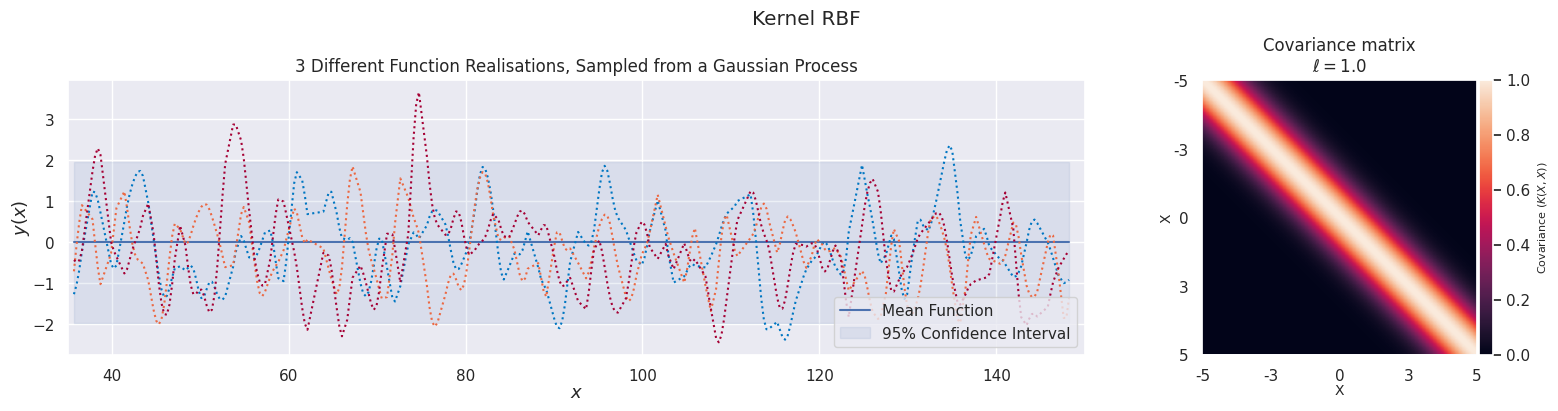

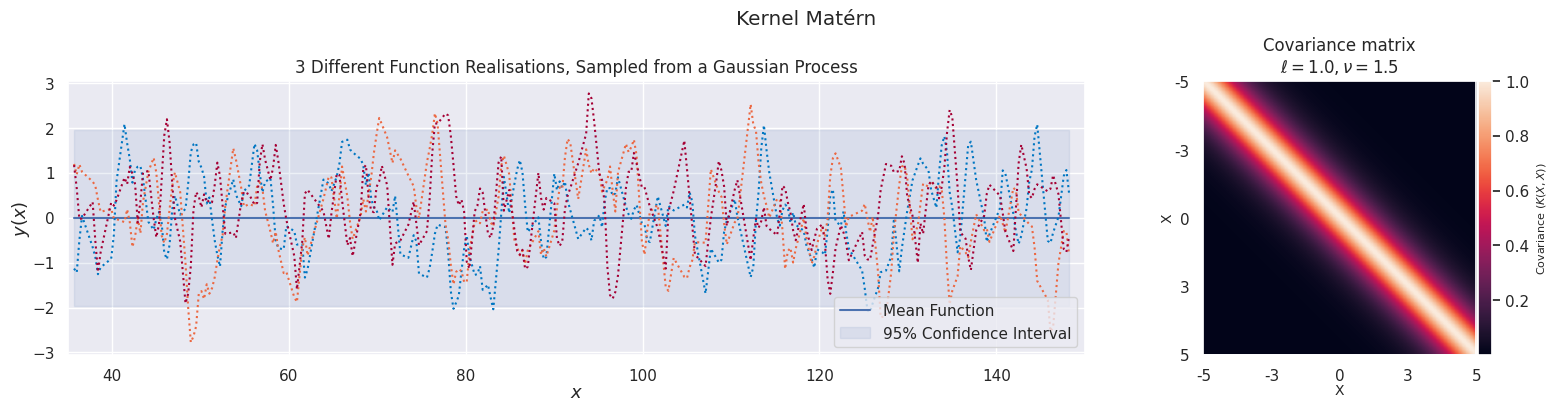

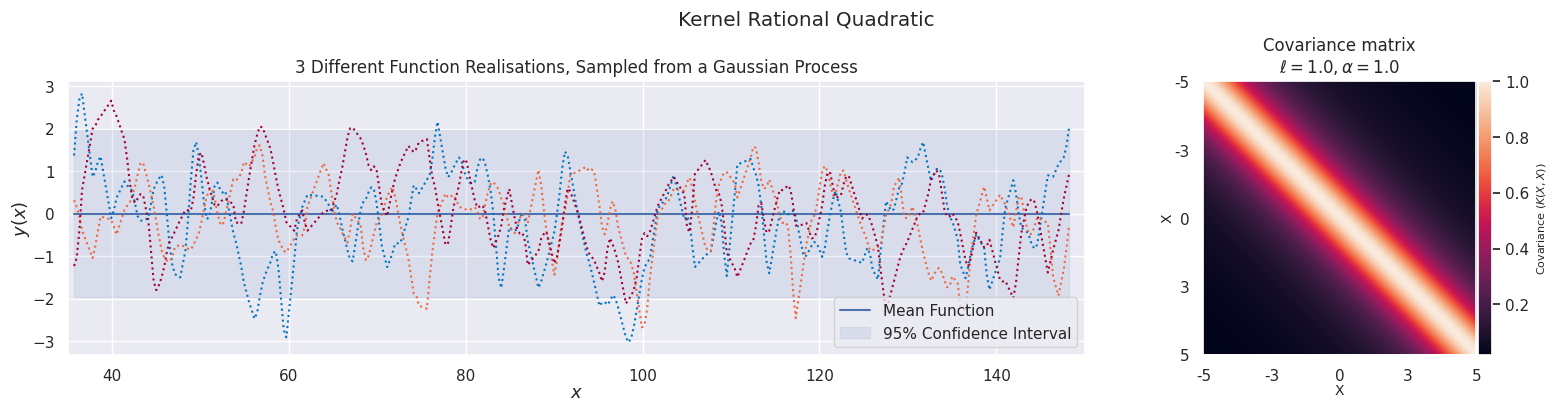

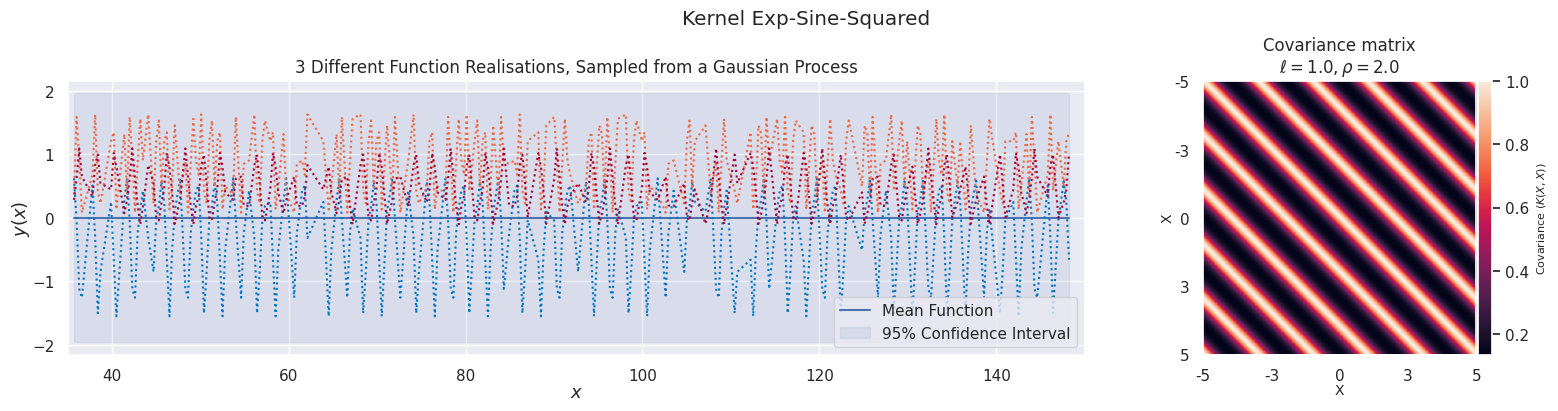

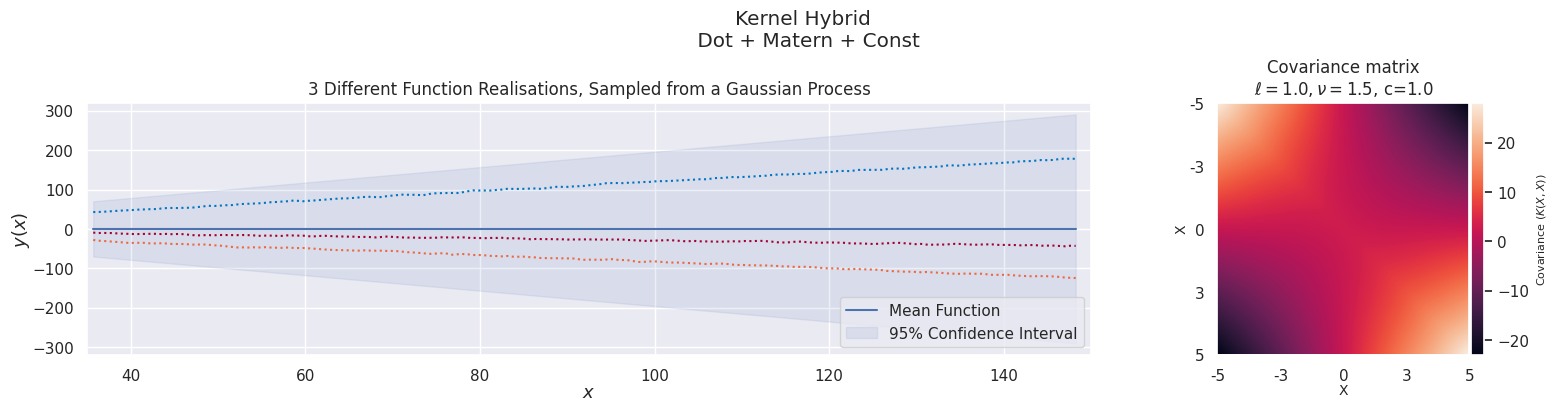

In [12]:
# Number of function realizations
nb_of_realizations = 3

# Generate input points
xlim = (35, 150)

nb_syn = 200
nb = len(X_train)

xlim_syn = (-5, 5)
X = np.expand_dims(np.linspace(*xlim_syn, nb_syn), 1)

# Loop over different kernels
for (kernel_type, kernel, setting) in zip(kernel_types, kernels, settings):

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    
    gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, width_ratios=[2, 1], height_ratios=[1], wspace=0.0, hspace=0.0)
    
    # Generate the covariance matrix using the current kernel and hyperparameters
    K = kernel(hyperparameters)
    cov = K(X_train)
    cov_syn = K(X)
    
    # Generate multiple realizations from the multivariate normal distribution
    y = np.random.multivariate_normal(mean=np.zeros(nb), cov=cov, size=nb_of_realizations)
    
    # Plot the kernel, function realizations, and covariance matrix
    plot_gp_samples(X_train, X, y, cov, cov_syn, setting, K, fig, gs, xlim, xlim_syn)
    
    fig.suptitle(f'Kernel {kernel_type}')
    
    plt.show()

# Gaussian Processes for Regression

<p style="text-align: justify; overflow-x:hidden;">In this section, the prior distributions from the previous section are used to predict new target values given the observed targets. By marginalising and applying <a href="https://interactivetextbooks.citg.tudelft.nl/dsaie/notebooks/0-preliminaries/lectures/probability_distributions.html#bayes-stdexpressions">Bayesian inversion</a> (using the standard result for multivariate Gaussians) twice, the result is a posterior predictive distribution, as such:</p> 

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>p</mi>
  <mo stretchy="false">(</mo>
  <mrow data-mjx-texclass="ORD">
    <mover>
      <mi>t</mi>
      <mo stretchy="false">^</mo>
    </mover>
  </mrow>
  <mo data-mjx-texclass="ORD" fence="false" stretchy="false">|</mo>
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">t</mi>
  </mrow>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mrow data-mjx-texclass="ORD">
    <mi data-mjx-variant="-tex-calligraphic" mathvariant="script">N</mi>
  </mrow>
  <mrow data-mjx-texclass="INNER">
    <mo data-mjx-texclass="OPEN">(</mo>
    <mrow data-mjx-texclass="ORD">
      <mover>
        <mi>t</mi>
        <mo stretchy="false">^</mo>
      </mover>
    </mrow>
    <mo data-mjx-texclass="ORD" fence="false" stretchy="false">|</mo>
    <mrow data-mjx-texclass="ORD">
      <mover>
        <mi>m</mi>
        <mo stretchy="false">^</mo>
      </mover>
    </mrow>
    <mo>,</mo>
    <msup>
      <mrow data-mjx-texclass="ORD">
        <mover>
          <mi>&#x3C3;</mi>
          <mo stretchy="false">^</mo>
        </mover>
      </mrow>
      <mn>2</mn>
    </msup>
    <mo data-mjx-texclass="CLOSE">)</mo>
  </mrow>
</math>

With posterior mean and variance:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mrow data-mjx-texclass="ORD">
    <mover>
      <mi>m</mi>
      <mo stretchy="false">^</mo>
    </mover>
  </mrow>
  <mo>=</mo>
  <mstyle>
    <mi>K</mi>
    <mrow data-mjx-texclass="INNER">
      <mo data-mjx-texclass="OPEN">(</mo>
      <mrow data-mjx-texclass="ORD">
        <mover>
          <mrow data-mjx-texclass="ORD">
            <mi mathvariant="bold">x</mi>
          </mrow>
          <mo stretchy="false">^</mo>
        </mover>
      </mrow>
      <mo>,</mo>
      <mrow data-mjx-texclass="ORD">
        <mi mathvariant="bold">X</mi>
      </mrow>
      <mo data-mjx-texclass="CLOSE">)</mo>
    </mrow>
  </mstyle>
  <msup>
    <mrow data-mjx-texclass="INNER">
      <mo data-mjx-texclass="OPEN">[</mo>
      <mi>K</mi>
      <mrow data-mjx-texclass="INNER">
        <mo data-mjx-texclass="OPEN">(</mo>
        <mrow data-mjx-texclass="ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mo>,</mo>
        <mrow data-mjx-texclass="ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mo data-mjx-texclass="CLOSE">)</mo>
      </mrow>
      <mo>+</mo>
      <msup>
        <mi>&#x3B2;</mi>
        <mrow data-mjx-texclass="ORD">
          <mo>&#x2212;</mo>
          <mn>1</mn>
        </mrow>
      </msup>
      <mrow data-mjx-texclass="ORD">
        <mi mathvariant="bold">I</mi>
      </mrow>
      <mo data-mjx-texclass="CLOSE">]</mo>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <mo>&#x2212;</mo>
      <mn>1</mn>
    </mrow>
  </msup>
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">t</mi>
  </mrow>
</math>
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msup>
    <mrow data-mjx-texclass="ORD">
      <mover>
        <mi>&#x3C3;</mi>
        <mo stretchy="false">^</mo>
      </mover>
    </mrow>
    <mn>2</mn>
  </msup>
  <mo>=</mo>
  <mstyle>
    <mi>k</mi>
    <mrow data-mjx-texclass="INNER">
      <mo data-mjx-texclass="OPEN">(</mo>
      <mrow data-mjx-texclass="ORD">
        <mover>
          <mrow data-mjx-texclass="ORD">
            <mi mathvariant="bold">x</mi>
          </mrow>
          <mo stretchy="false">^</mo>
        </mover>
      </mrow>
      <mo>,</mo>
      <mrow data-mjx-texclass="ORD">
        <mover>
          <mrow data-mjx-texclass="ORD">
            <mi mathvariant="bold">x</mi>
          </mrow>
          <mo stretchy="false">^</mo>
        </mover>
      </mrow>
      <mo data-mjx-texclass="CLOSE">)</mo>
    </mrow>
  </mstyle>
  <mo>&#x2212;</mo>
  <mstyle>
    <mi>K</mi>
    <mrow data-mjx-texclass="INNER">
      <mo data-mjx-texclass="OPEN">(</mo>
      <mrow data-mjx-texclass="ORD">
        <mover>
          <mrow data-mjx-texclass="ORD">
            <mi mathvariant="bold">x</mi>
          </mrow>
          <mo stretchy="false">^</mo>
        </mover>
      </mrow>
      <mo>,</mo>
      <mrow data-mjx-texclass="ORD">
        <mi mathvariant="bold">X</mi>
      </mrow>
      <mo data-mjx-texclass="CLOSE">)</mo>
    </mrow>
  </mstyle>
  <msup>
    <mrow data-mjx-texclass="INNER">
      <mo data-mjx-texclass="OPEN">[</mo>
      <mi>K</mi>
      <mrow data-mjx-texclass="INNER">
        <mo data-mjx-texclass="OPEN">(</mo>
        <mrow data-mjx-texclass="ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mo>,</mo>
        <mrow data-mjx-texclass="ORD">
          <mi mathvariant="bold">X</mi>
        </mrow>
        <mo data-mjx-texclass="CLOSE">)</mo>
      </mrow>
      <mo>+</mo>
      <msup>
        <mi>&#x3B2;</mi>
        <mrow data-mjx-texclass="ORD">
          <mo>&#x2212;</mo>
          <mn>1</mn>
        </mrow>
      </msup>
      <mrow data-mjx-texclass="ORD">
        <mi mathvariant="bold">I</mi>
      </mrow>
      <mo data-mjx-texclass="CLOSE">]</mo>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <mo>&#x2212;</mo>
      <mn>1</mn>
    </mrow>
  </msup>
  <mstyle>
    <mi>K</mi>
    <mrow data-mjx-texclass="INNER">
      <mo data-mjx-texclass="OPEN">(</mo>
      <mrow data-mjx-texclass="ORD">
        <mi mathvariant="bold">X</mi>
      </mrow>
      <mo>,</mo>
      <mrow data-mjx-texclass="ORD">
        <mover>
          <mrow data-mjx-texclass="ORD">
            <mi mathvariant="bold">x</mi>
          </mrow>
          <mo stretchy="false">^</mo>
        </mover>
      </mrow>
      <mo data-mjx-texclass="CLOSE">)</mo>
    </mrow>
  </mstyle>
  <mo>+</mo>
  <msup>
    <mi>&#x3B2;</mi>
    <mrow data-mjx-texclass="ORD">
      <mo>&#x2212;</mo>
      <mn>1</mn>
    </mrow>
  </msup>
</math>

<p style="text-align: justify; overflow-x:hidden;">While it is possible to implement the previous and following steps manually, here the <a href="https://scikit-learn.org/stable/modules/gaussian_process.html">Gaussian Process Regressor</a> from Scikit Learn is used that includes all of these processes. The regressor will optimise for the kernel’s parameters by maximising the log-marginal-likelihood based on the passed optimiser.</p> 

## Posterior Distributions

In [13]:
def GP_prediction(kernel, X_train, y_train, X_test, gpr=None):
    """
    Perform Gaussian Process regression with hyperparameter tuning.

    Parameters:
    - kernel: The kernel function for Gaussian Process regression.
    - X_train: Training input data.
    - y_train: Training target values.
    - X_test: Test input data for prediction.
    - gpr (GaussianProcessesRegressor): the gaussian process regressor for the best kernel

    Returns:
    - f_mean: Predicted mean for the test points.
    - f_var: Predicted variance for the test points.
    - gp: Trained GaussianProcessRegressor model.
    """
    if gpr is not None:
        gp = gpr
    else:
        # Construct GP regression model (with hyperparameter tuning)
        gp = GPR(kernel=kernel, n_restarts_optimizer=5, random_state=seed)

        # Fitting the GP model
        gp.fit(X_train, y_train)

    # Make predictions on the test points
    f_mean, f_var = gp.predict(X_test, return_std=True)

    return f_mean, f_var, gp

In [14]:
def plot_posteriors(X_train, y_train, X_test, testing, gpr=None, gps=None):
    """
    Plot posterior predictions for Gaussian Processes with different kernels.

    Parameters:
    - X_train (numpy array): Training data features.
    - y_train (numpy array): Training data labels.
    - X_test (numpy array): Test data features.
    - testing (boolean): Indicate if testing is on or off
    - gpr (GaussianProcessesRegressor): the gaussian process regressor for the best kernel

    Output:
    - Plots showing posterior predictions with mean function, confidence interval,
      and samples from the posterior for different Gaussian Process kernels.
    """

    for idx, (kernel_type, kernel, setting) in enumerate(zip(kernel_types, kernels, settings)):

        # Create a new figure
        fig = plt.figure(figsize=(16, 6), constrained_layout=True)

        # Mark the observations or test observations based on the 'testing' flag
        observations_color = '#d662e3' if not testing else '#32a852'
        observations_label = 'Train Observations' if not testing else 'Test Observations'
        plt.scatter(X_train, y_train,
                    marker='o', color=observations_color, label=observations_label)

        # Initialize Gaussian Process with the specified kernel and hyperparameters
        K = kernel(hyperparameters)

        # Make predictions using Gaussian Process regression
        if testing:
            f_mean, f_var, gp = GP_prediction(K, X_train, y_train, X_test, gpr[idx])
            # Plot mean function with line and markers ('o') if testing is true
            plt.plot(X_test, f_mean, 'b-', marker='o', label='Mean Function')
        else:
            f_mean, f_var, gp = GP_prediction(K, X_train, y_train, X_test, None)
            # Plot mean function with a line if testing is false
            plt.plot(X_test, f_mean, 'b-', label='Mean Function')

            # Save the GP
            gps.append(gp)

        # Plot 95% confidence interval
        upper_bound = f_mean + 1.96 * f_var
        lower_bound = f_mean - 1.96 * f_var
        plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color='b', alpha=0.1, label='95% Confidence Interval')

        # Draw samples from the posterior and plot
        plt.plot(X_test, gp.sample_y(X_test, n_samples=5, random_state=seed), ':')

        # Set axis labels
        plt.ylabel('$y(x)$', fontsize=13, labelpad=0)
        plt.xlabel('$x$', fontsize=13, labelpad=0)

        # Set plot title with kernel information
        title_suffix = str(gpr[idx].kernel_) if testing else f'{setting}, σ = 1.0'
        plt.title(f'Kernel: {kernel_type} with {title_suffix}\n 5 Different Function Realisations, Sampled from a Gaussian Process')

        # Add legend to the plot
        plt.legend(loc='upper right')

        # Set limits on the x-axis
        plt.xlim(np.min(X_test), np.max(X_test))

        # Show the plots
        plt.show()

        # Close the figure to prevent multiple plots
        plt.close(fig)

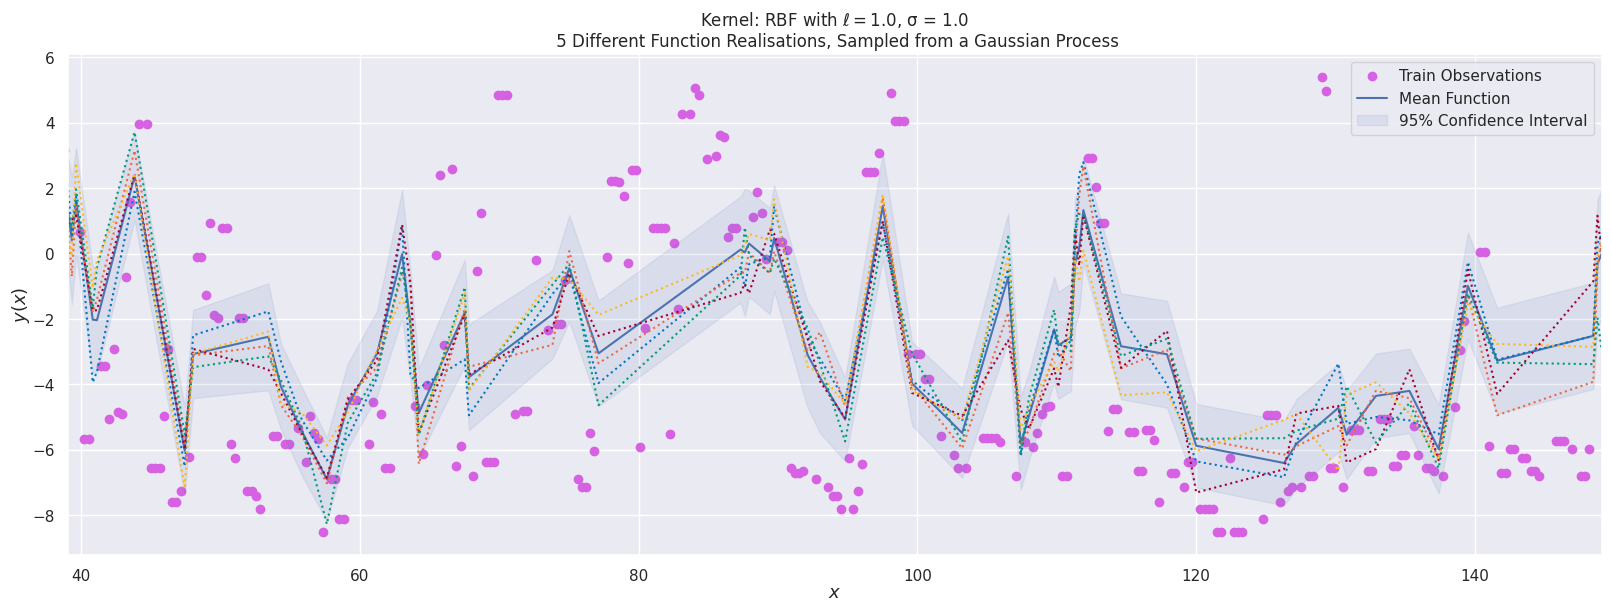

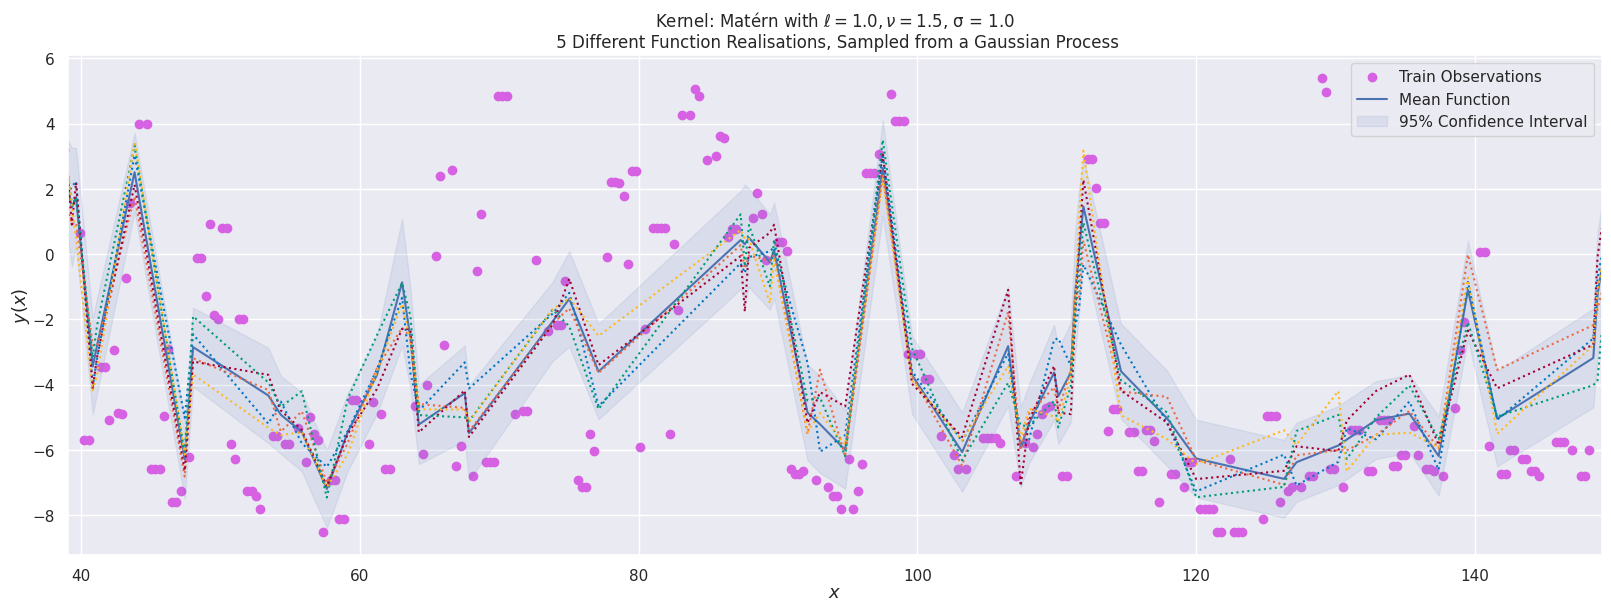

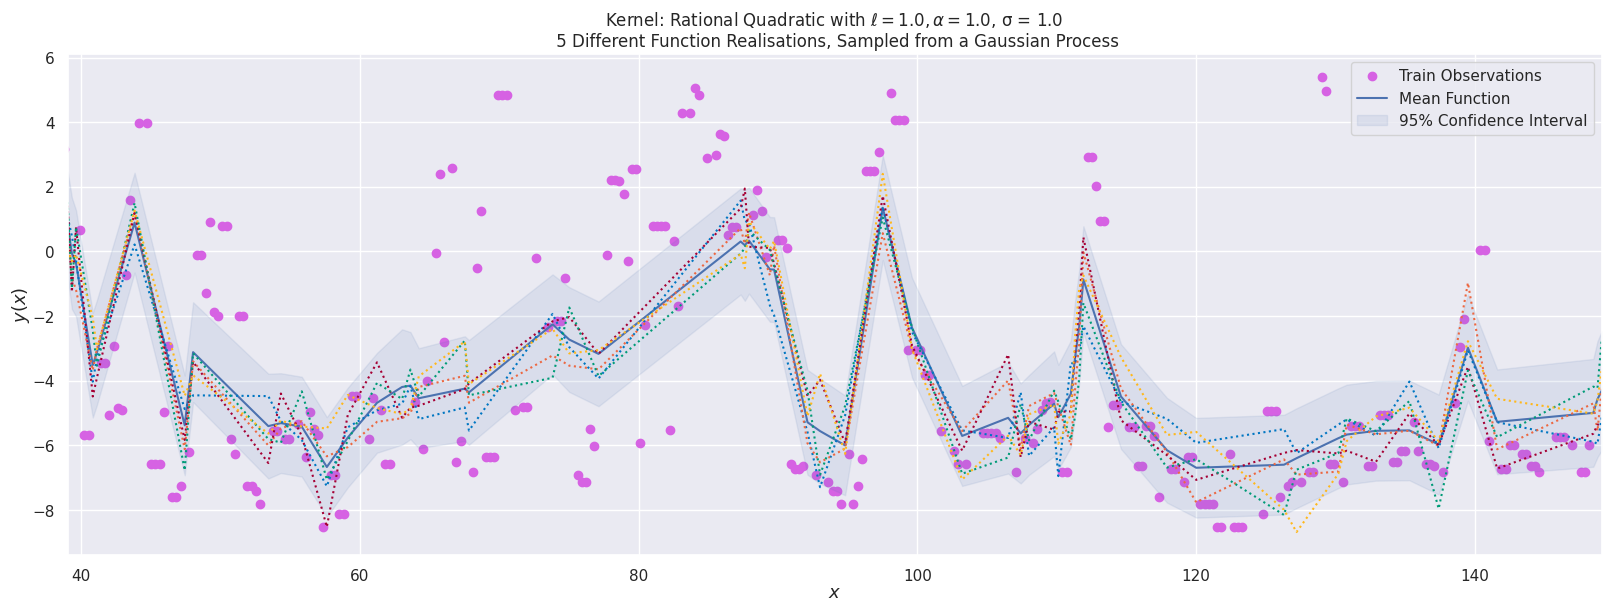

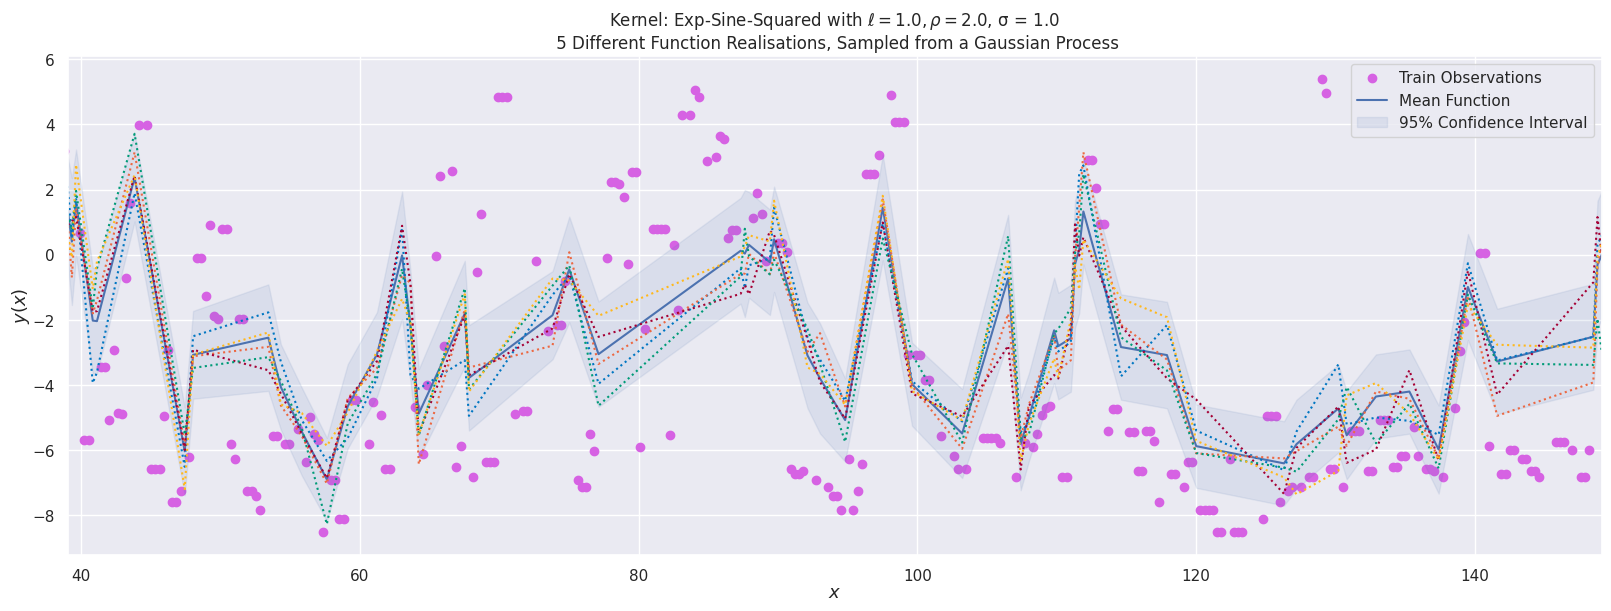

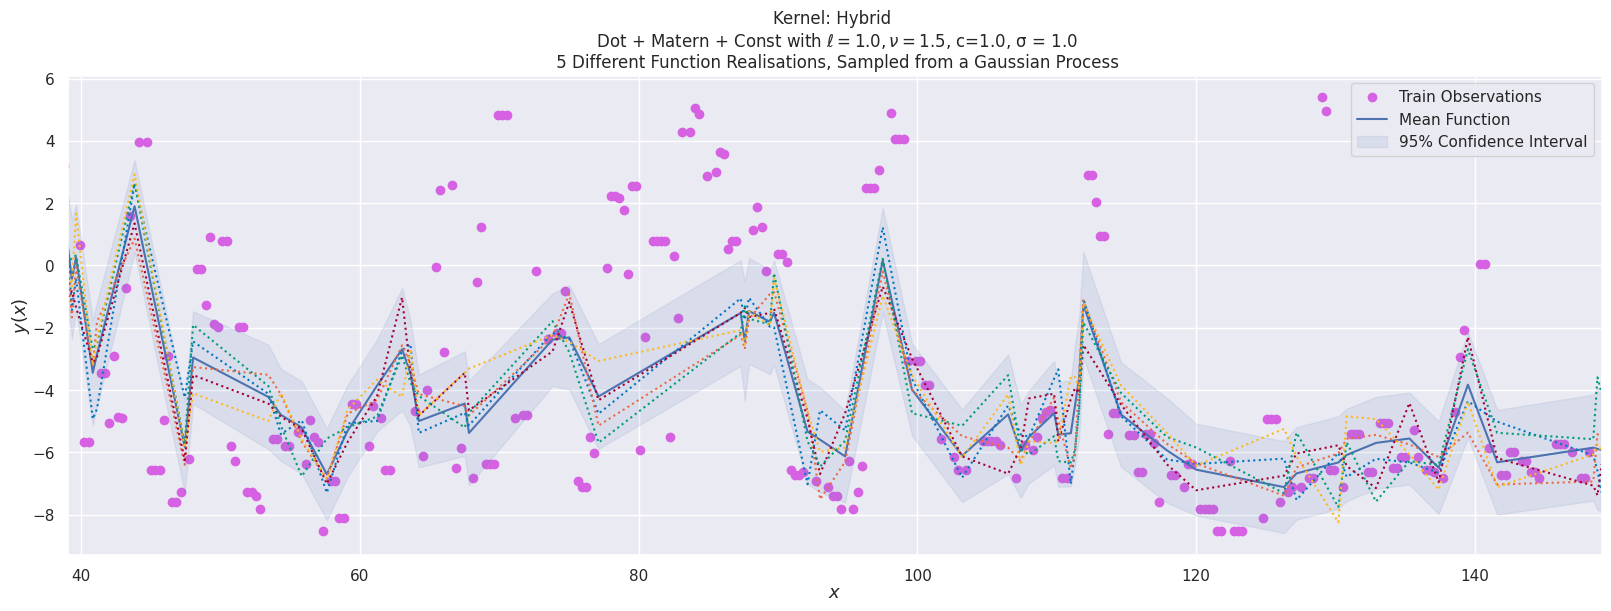

In [15]:
white_kernel_state = True

gps = []

plot_posteriors(X_train, y_train, X_test, False, None, gps)

## Log-Marginal Likelihood Landscape

In [16]:
def marginal_likelihood(kernel,X_train, y_train, noise):

    kernel += white_kernel(noise_level=noise)

    # Construct GP regression model (without hyperparameter tuning)
    gp = GPR(kernel=kernel, optimizer=None)

    # Compute posterior GP and evaluate morginal likelihood
    gp.fit(X_train, y_train)

    return gp.log_marginal_likelihood()

In [17]:
white_kernel_state = False

ls = np.logspace(-1, 2, 50)
s2s = np.logspace(-1, 2, 50)

LML_RBF = [[marginal_likelihood(rbf_kernel(hyperparameters, length_scale=l), X_train, y_train, s2) for l in ls] for s2 in s2s]

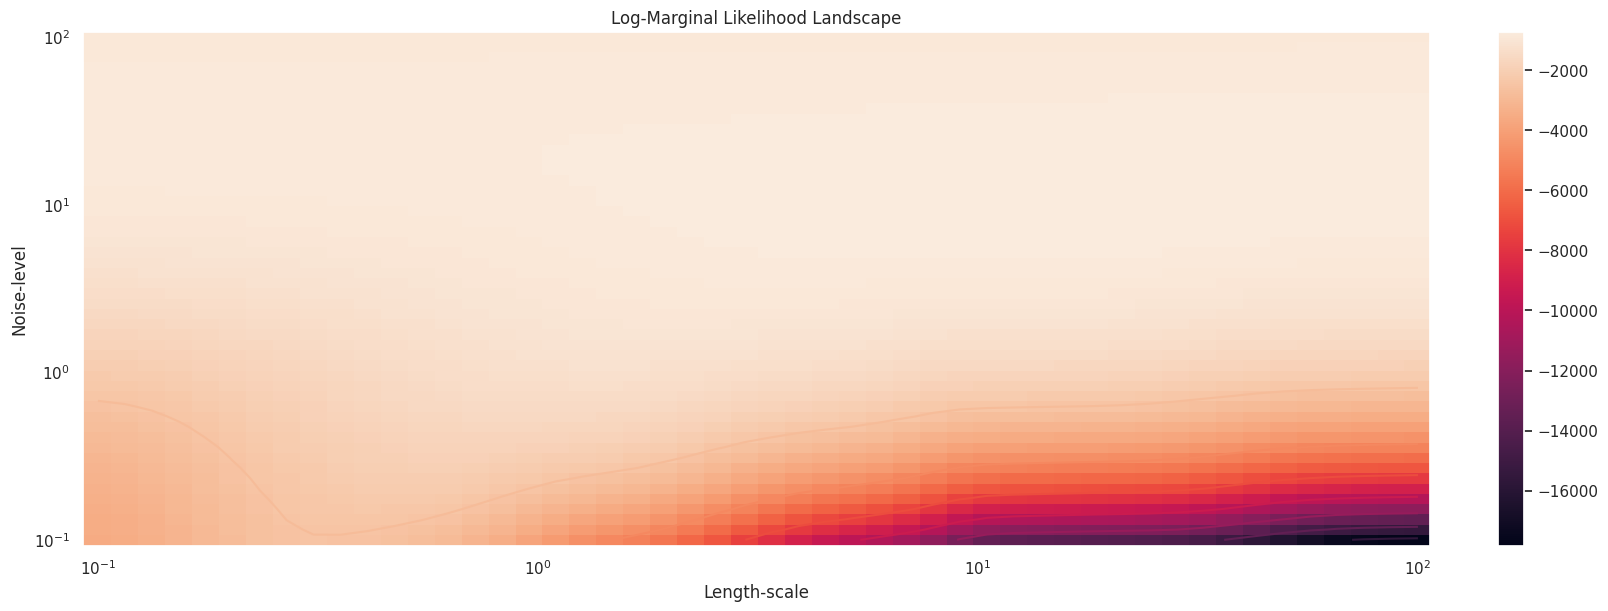

In [18]:
fig = plt.figure(figsize=(16, 6), constrained_layout=True)
pclr = plt.pcolor(ls, s2s, LML_RBF)
colorbar = plt.colorbar(pclr)
plt.contour(ls, s2s, LML_RBF)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-Marginal Likelihood Landscape")
plt.show();

# Model Selection

In [19]:
NUM_FOLDS = 10
# Define the cross-validator 
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=seed)

# Initialize a list to store the best models and corresponding performance based on MSE and NLVDL
best_models_mse = {kernel_type: {'model': None, 'mse': float('inf')} for kernel_type in kernel_types}
best_models_nlvdl = {kernel_type: {'model': None, 'nlvdl': float('-inf')} for kernel_type in kernel_types}

# Dictionary to store predictions and covariances for each kernel
kernel_results = {kernel_type: {'MSE_folds': [], 'NLVDL_folds': []} for kernel_type in kernel_types}

In [20]:
for kernel, kernel_type, gp in zip(kernels, kernel_types, gps):
    for i, (train_index, test_index) in enumerate(kf.split(X_val)):

        K = kernel(hyperparameters)

        # Create a new GaussianProcessRegressor instance for each fold and each kernel
        gpr = gp

        # Use the indices from kf.split to create training and validation sets
        X_train_fold, X_val_fold = X_val[train_index], X_val[test_index]
        y_train_fold, y_val_fold = y_val[train_index], y_val[test_index]

        # Fit the model
        gpr.fit(X_train_fold, y_train_fold)

        # Make predictions and calculate covariance on the validation set
        y_pred_val, cov_pred_val = gpr.predict(X_val_fold, return_cov=True)

        mse = mean_squared_error(y_val_fold, y_pred_val)
        nlvdl_val = np.sum(-0.5 * np.log(cov_pred_val.diagonal()) - 0.5 * ((y_val_fold - y_pred_val) ** 2) / cov_pred_val.diagonal() - 0.5 * np.log(2 * np.pi))

        # Save predictions and covariances
        kernel_results[kernel_type]['MSE_folds'].append(mse)
        kernel_results[kernel_type]['NLVDL_folds'].append(nlvdl_val)

        # Update best models based on MSE
        if mse < best_models_mse[kernel_type]['mse']:
            best_models_mse[kernel_type]['model'] = gpr
            best_models_mse[kernel_type]['mse'] = mse

        # Update best models based on NLVDL
        if nlvdl_val > best_models_nlvdl[kernel_type]['nlvdl']:
            best_models_nlvdl[kernel_type]['model'] = gpr
            best_models_nlvdl[kernel_type]['nlvdl'] = nlvdl_val

# Testing

In [21]:
def test_kernels(kernel_test_results=None):
    """
    Evaluate the performance of Gaussian Process Regressor models with different kernels on a test dataset.

    Parameters:
    - best_models_mse (dict): Dictionary containing the best GPR models based on the smallest MSE for different kernels.
    - best_models_nlvdl (dict): Dictionary containing the best GPR models based on the highest NLVDL for different kernels.
    - X_test (numpy array): Test dataset features.
    - y_test (numpy array): True target values for the test dataset.
    - kernel_test_results (dict, optional): Dictionary to store test results (MSE and NLVDL) for each kernel. Default is None.

    Returns:
    - mse_prediction_results (list): List of predicted target values for the test dataset using the model with the smallest MSE.
    - nlvdl_prediction_results (list): List of predicted target values for the test dataset using the model with the highest NLVDL.
    """

    # Initialize empty lists to store test results
    mse_test_results = []
    nlvdl_test_results = []

    # Initialize empty lists to store the preditions
    mse_prediction_results = []
    nlvdl_prediction_results = []

    # Iterate over best models for MSE and NLVDL
    for (k1, v1), (k2, v2) in zip(best_models_mse.items(), best_models_nlvdl.items()):
    
        # Select the best model GPR
        best_mse_gpr = v1['model']
        best_nlvdl_gpr = v2['model']

        # Make predictions using the model with the smallest MSE and highest NLVDL
        y_pred_mse, _ = best_mse_gpr.predict(X_test, return_std=True)
        y_pred_nlvdl, cov_pred_nlvdl = best_nlvdl_gpr.predict(X_test, return_std=True)

        # Evaluate MSE and NLVDL for the model with the smallest MSE and highest NLVDL
        mse_test_result = mean_squared_error(y_test, y_pred_mse)
        nlvdl_test_result = np.sum(-0.5 * np.log(cov_pred_nlvdl) - 0.5 * ((y_test - y_pred_nlvdl) ** 2) / cov_pred_nlvdl - 0.5 * np.log(2 * np.pi))

        # Append test results to the lists
        mse_test_results.append(mse_test_result)
        nlvdl_test_results.append(nlvdl_test_result)

        if kernel_test_results is not None:
            # Update test results for each kernel in the dictionary
            kernel_test_results[k1]['MSE_test'].append(mse_test_result)
            kernel_test_results[k1]['NLVDL_test'].append(nlvdl_test_result)

        # Append the predictions to the lists
        mse_prediction_results.append(y_pred_mse)
        nlvdl_prediction_results.append(y_pred_nlvdl)

    # Return predicted values for MSE and NLVDL
    return mse_prediction_results, nlvdl_prediction_results

In [22]:
# Dictionary to store predictions and covariances for each kernel
kernel_test_results = {kernel_type: {'MSE_test': [], 'NLVDL_test': []} for kernel_type in kernel_types}

_, _ = test_kernels(kernel_test_results)

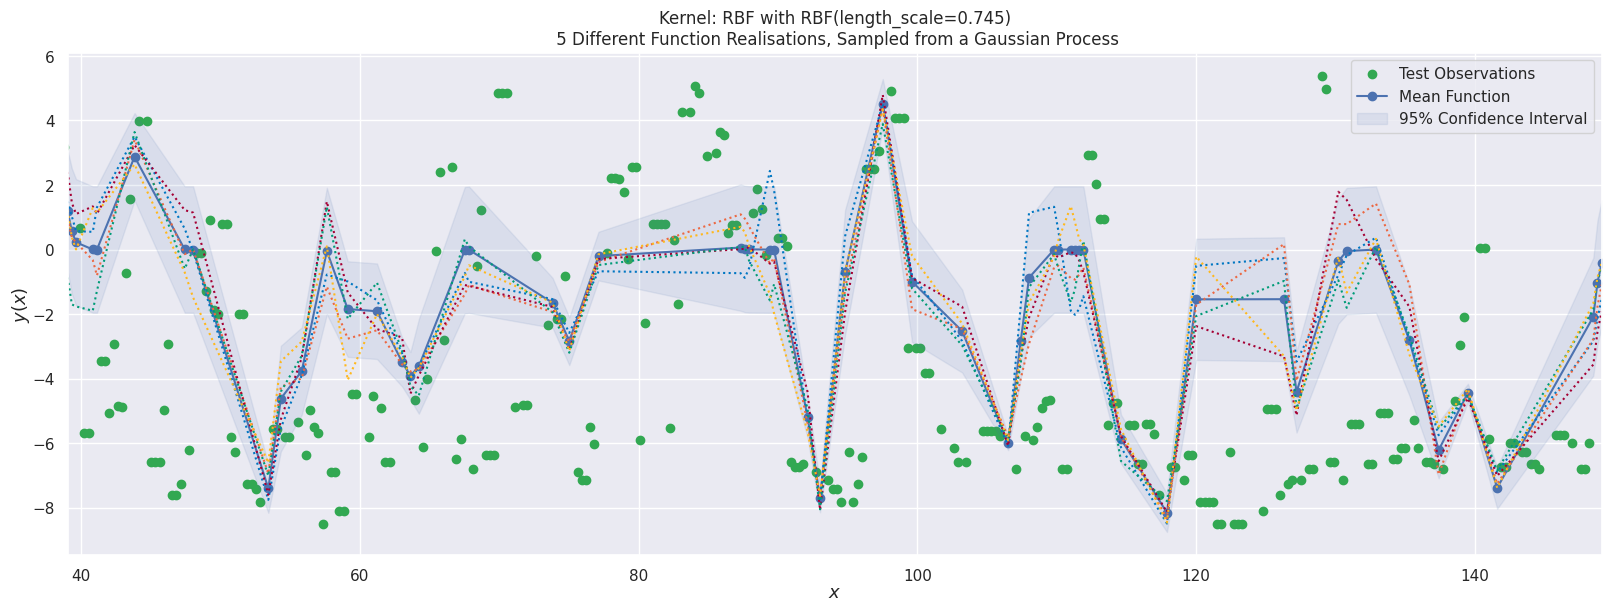

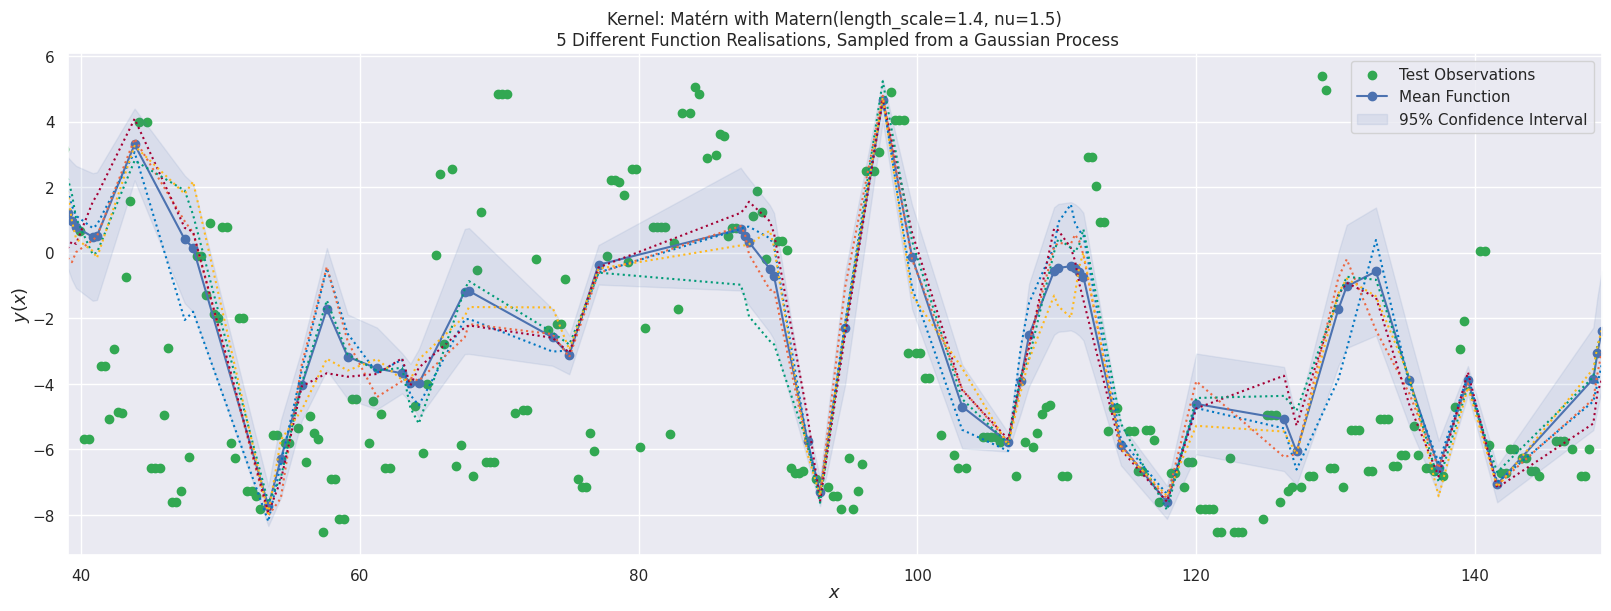

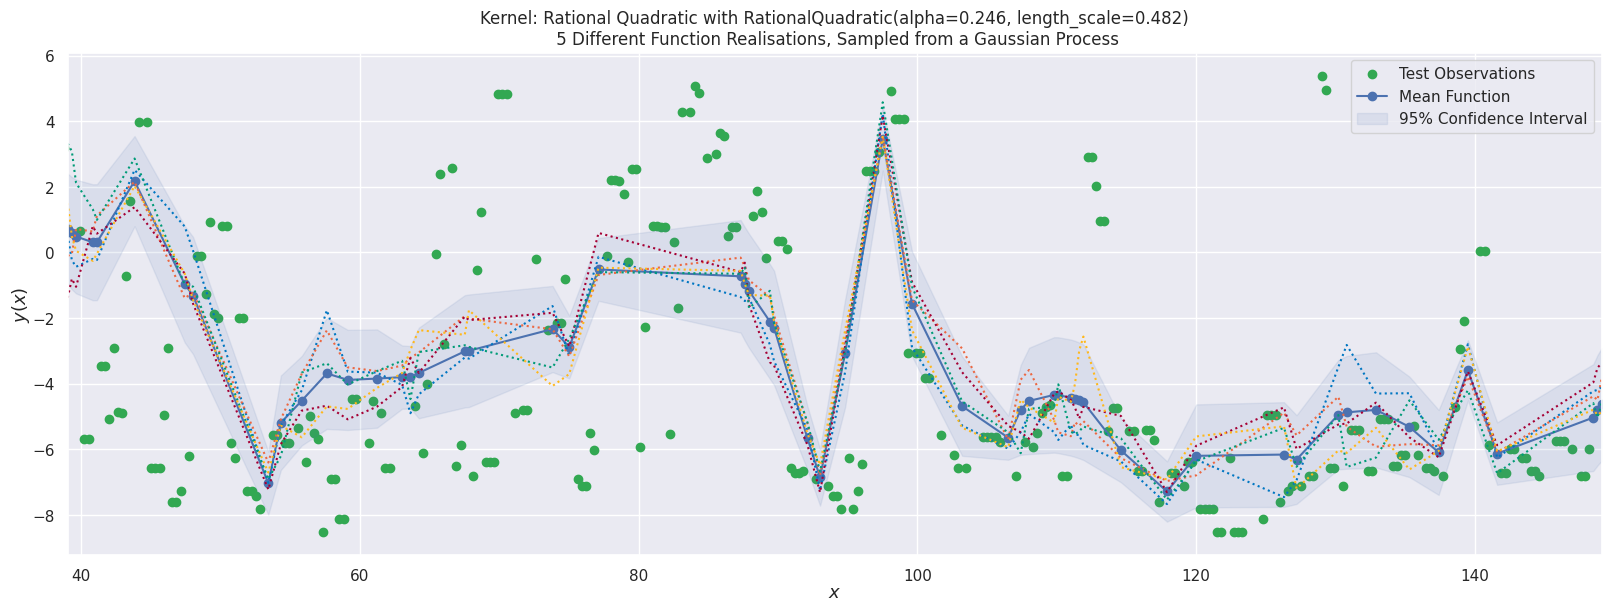

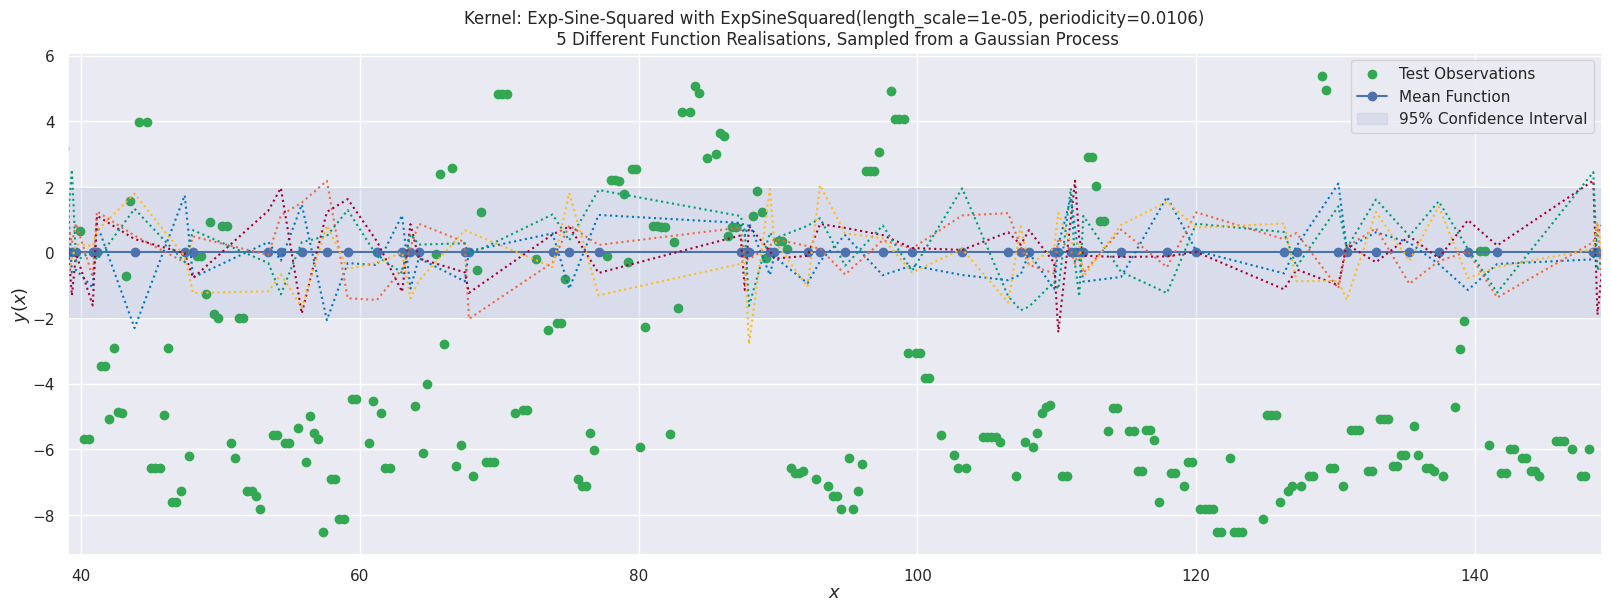

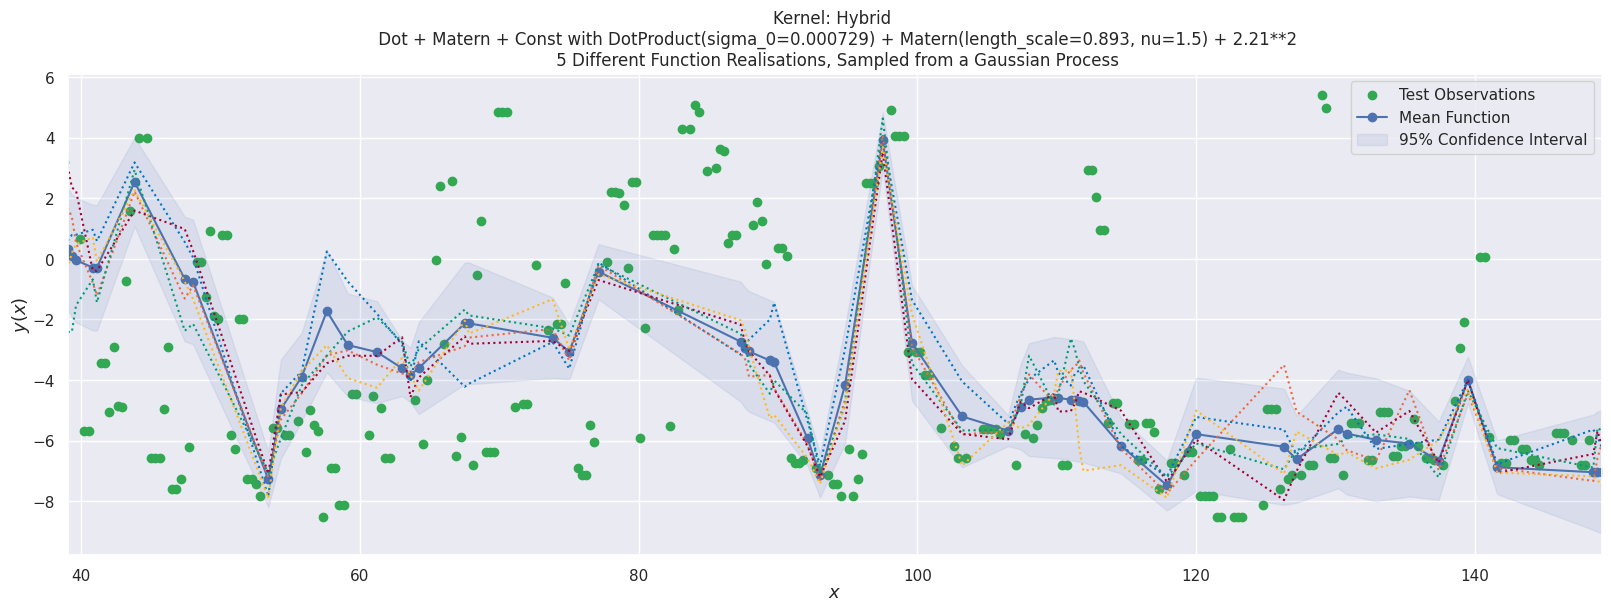

In [23]:
# Extract 'model' values into a list
models_list = [entry['model'] for entry in best_models_mse.values()]

plot_posteriors(X_train, y_train, X_test, True, gpr=models_list)

# Results

In [24]:
# Print the best performance of each kernel based on MSE
print("\nBest Performance based on MSE:")
# Create a table
table_mse = PrettyTable()
table_mse.field_names = ["Model", "Best MSE (Validation)", "Kernel Parameters"]
table_mse.align["Model"] = "l"  # Left-align the "Model" column
table_mse.align["Kernel Parameters"] = "r"  # Right-align the "Error" column
for kernel, info in best_models_mse.items():
    table_mse.add_row([kernel, f"{info['mse']:.3f}", info['model'].kernel_])
print(table_mse)

# Print the best performance of each kernel based on NLVDL
print("\nBest Performance based on NLVDL:")
# Create a table
table_nlvdl = PrettyTable()
table_nlvdl.field_names = ["Model", "Best NLVDL (Validation)", "Kernel Parameters"]
table_nlvdl.align["Model"] = "l"  # Left-align the "Model" column
table_nlvdl.align["Kernel Parameters"] = "r"  # Right-align the "Error" column
for kernel, info in best_models_nlvdl.items():
    table_nlvdl.add_row([kernel, f"{info['nlvdl']:.3f}", info['model'].kernel_])
print(table_nlvdl)


Best Performance based on MSE:
+-----------------------+-----------------------+-----------------------------------------------------------------------------+
| Model                 | Best MSE (Validation) |                                                           Kernel Parameters |
+-----------------------+-----------------------+-----------------------------------------------------------------------------+
| RBF                   |         1.234         |                                                     RBF(length_scale=0.745) |
| Matérn                |         0.976         |                                            Matern(length_scale=1.4, nu=1.5) |
| Rational Quadratic    |         0.949         |                          RationalQuadratic(alpha=0.246, length_scale=0.482) |
| Exp-Sine-Squared      |         1.234         |                      ExpSineSquared(length_scale=1e-05, periodicity=0.0106) |
| Hybrid                |         0.764         | DotProduct(sigma_0=0.0

In [25]:
# Convert to pandas DataFrames
mse_df = pd.DataFrame({key: val['MSE_folds'] for key, val in kernel_results.items()})
nlvdl_df = pd.DataFrame({key: val['NLVDL_folds'] for key, val in kernel_results.items()})

mse_test_df = pd.DataFrame({key: val['MSE_test'] for key, val in kernel_test_results.items()})
nlvdl_test_df = pd.DataFrame({key: val['NLVDL_test'] for key, val in kernel_test_results.items()})

# Melt the DataFrame to convert it to long format
df_test_mse = pd.melt(mse_test_df, var_name='Column', value_name='Value')
df_test_nldvl = pd.melt(nlvdl_test_df, var_name='Column', value_name='Value')

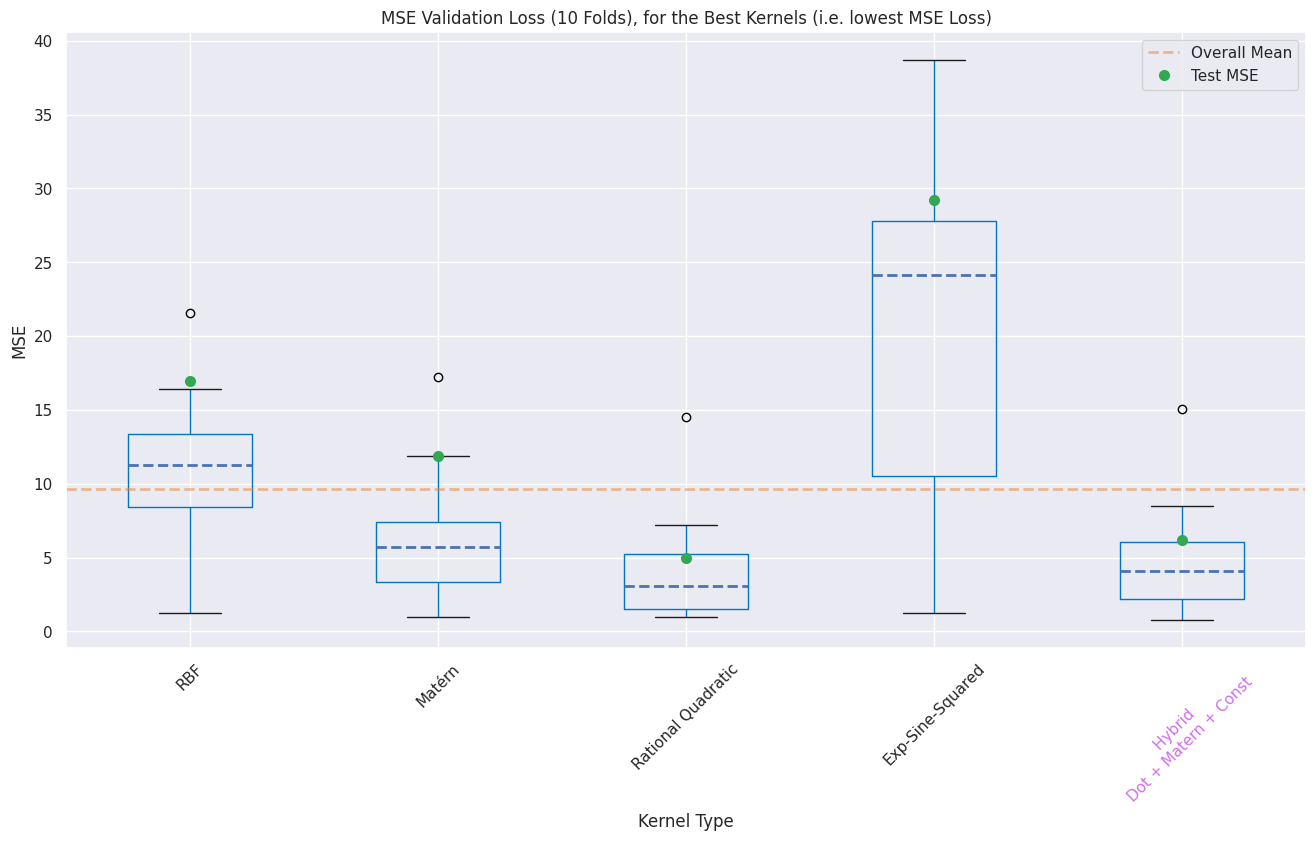

In [26]:
fig, ax = plt.subplots(figsize=(16,8))

median_properties = {
    'color': 'b',
    'linestyle': '--',
    'linewidth': 2
}

sns.stripplot(data=df_test_mse, x='Column', y='Value', jitter=True, marker='o', s=8, color='#32a852')

boxplot_positions = [pos for pos in range(5)]
mse_df.boxplot(ax=ax, medianprops=median_properties, rot=45, positions=boxplot_positions)

# Calculate mean values per column
mean_values = mse_df.mean().tolist()

# Calculate the overall mean of mean values
overall_mean = np.mean(mean_values)

# Plot a mean line across all items
plt.axhline(y=overall_mean, color='#eb8334', alpha=0.5, linestyle='--', linewidth=2, label='Overall Mean')

# Manually create a legend label
ax.plot([], [], color='#32a852', marker='o', label='Test MSE', markersize=7, linestyle='None')

# Customize the last tick label on the x-axis
last_tick_label = ax.get_xticklabels()[-1]
last_tick_label.set_color('#d16ef0')

plt.ylabel('MSE')
plt.xlabel('Kernel Type')
plt.title(f'MSE Validation Loss ({NUM_FOLDS} Folds), for the Best Kernels (i.e. lowest MSE Loss)');
plt.legend(loc='upper right')

plt.show();

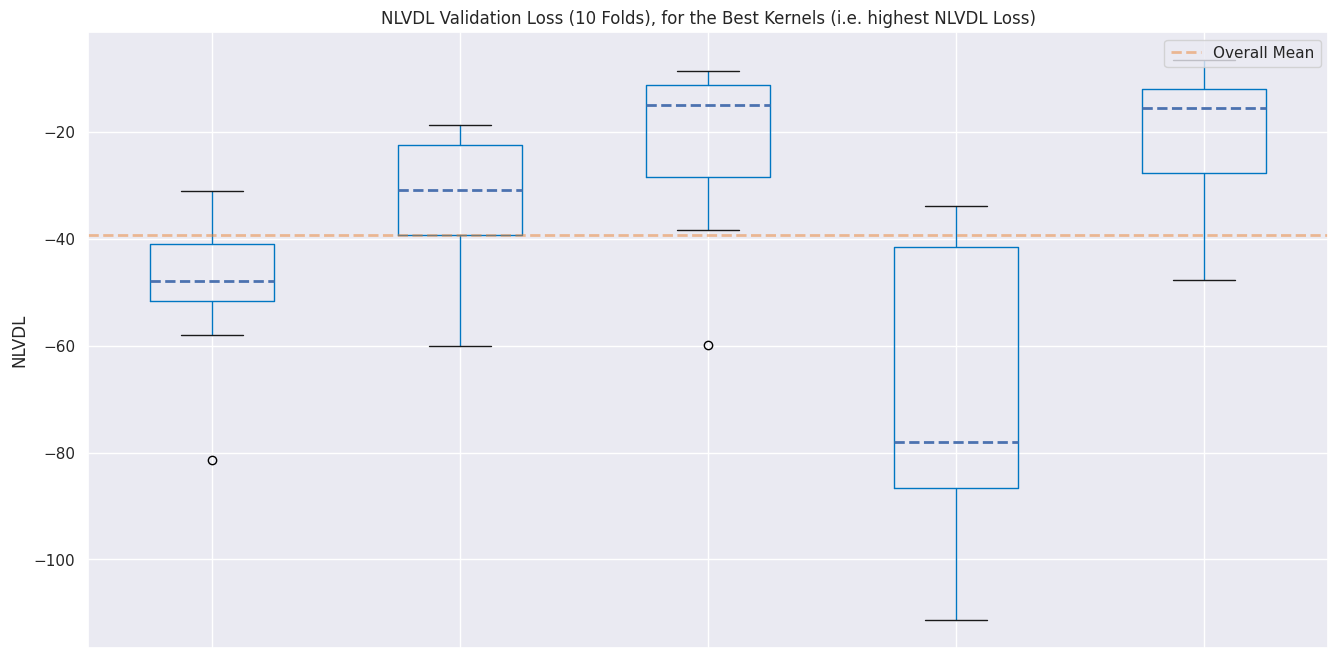

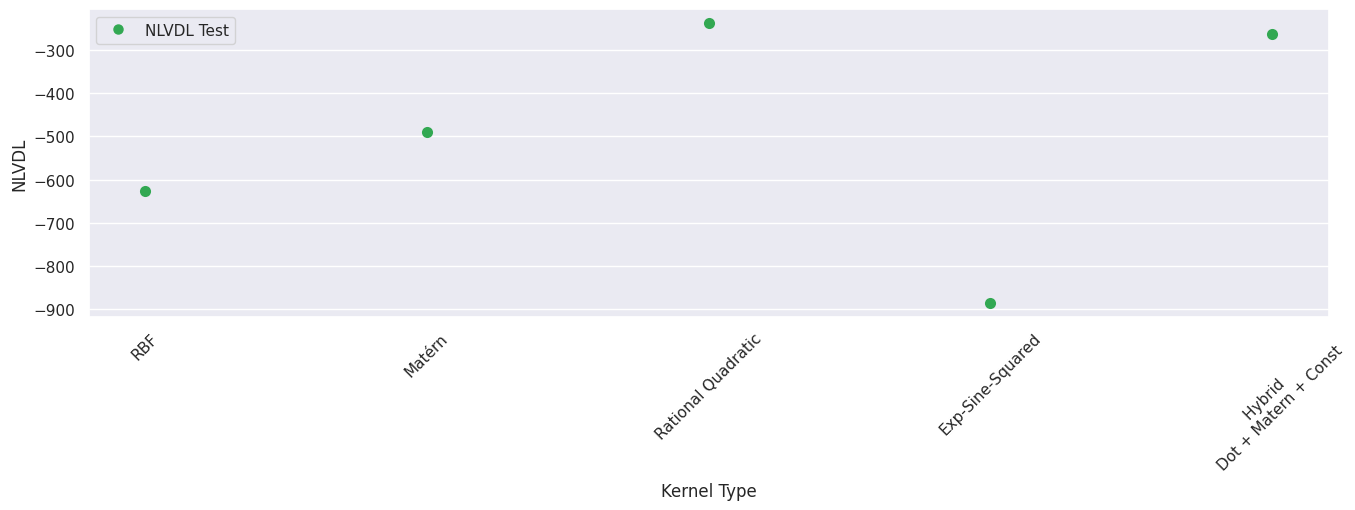

In [27]:
fig, ax = plt.subplots(figsize=(16,8))

boxplot_positions = [pos for pos in range(5)]
nlvdl_df.boxplot(ax=ax, medianprops=median_properties, rot=45, positions=boxplot_positions)

# Calculate mean values per column
mean_values = nlvdl_df.mean().tolist()

# Calculate the overall mean of mean values
overall_mean = np.mean(mean_values)

# Plot a mean line across all items
plt.axhline(y=overall_mean, color='#eb8334', alpha=0.5, linestyle='--', linewidth=2, label='Overall Mean')

# Customize the last tick label on the x-axis
last_tick_label = ax.get_xticklabels()[-1]
last_tick_label.set_color('#d16ef0')

plt.ylabel('NLVDL')
plt.title(f'NLVDL Validation Loss ({NUM_FOLDS} Folds), for the Best Kernels (i.e. highest NLVDL Loss)');
plt.legend(loc='upper right')

# Disable x-axis tick labels
ax.set_xticklabels([])

plt.show();

fig, ax = plt.subplots(figsize=(16,4))

sns.stripplot(data=df_test_nldvl, x='Column', y='Value', jitter=True, marker='o', s=8, color='#32a852', label='')

plt.ylabel('NLVDL')
plt.xlabel('Kernel Type')

# Rotate x-axis tick labels for the specific subplot
ax.set_xticklabels(kernel_types, rotation=45)

# Manually create a legend label
ax.plot([], [], color='#32a852', marker='o', label='NLVDL Test', markersize=6.5, linestyle='None')

plt.legend()
plt.show();

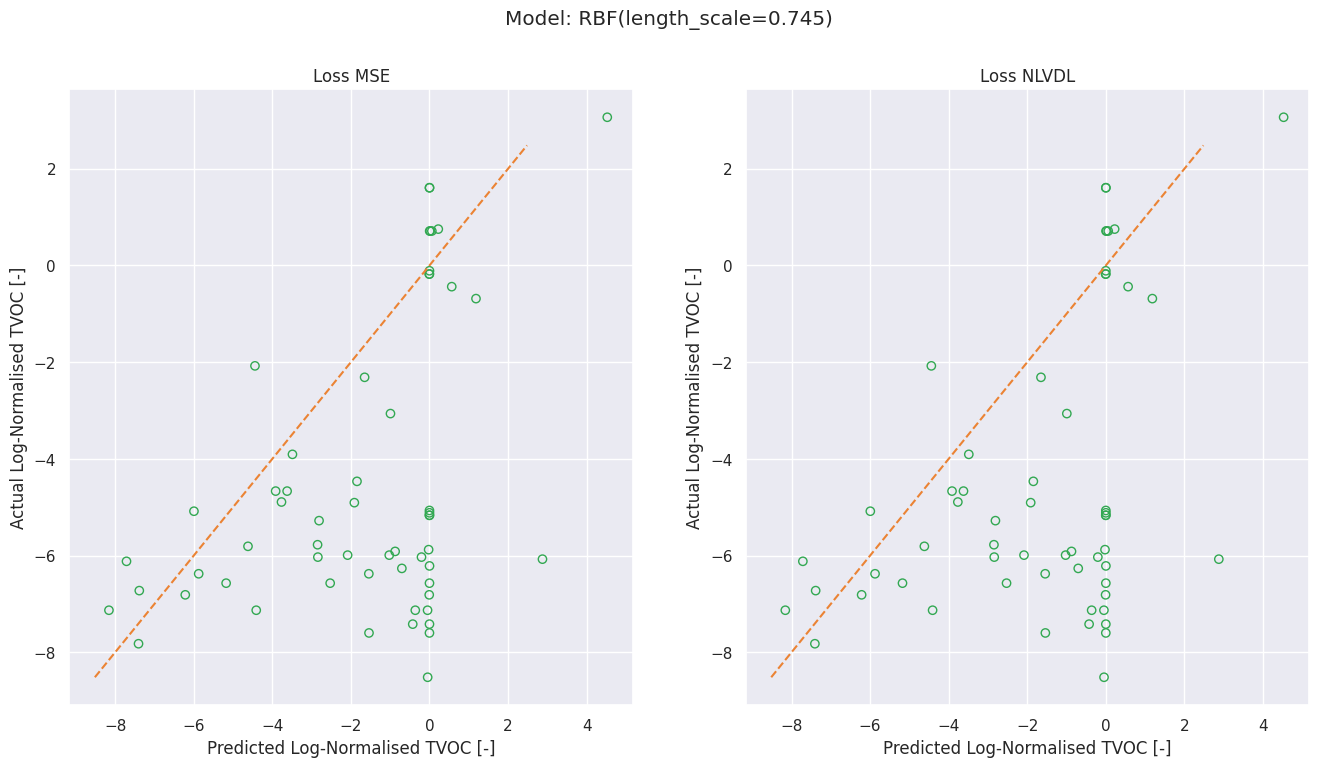

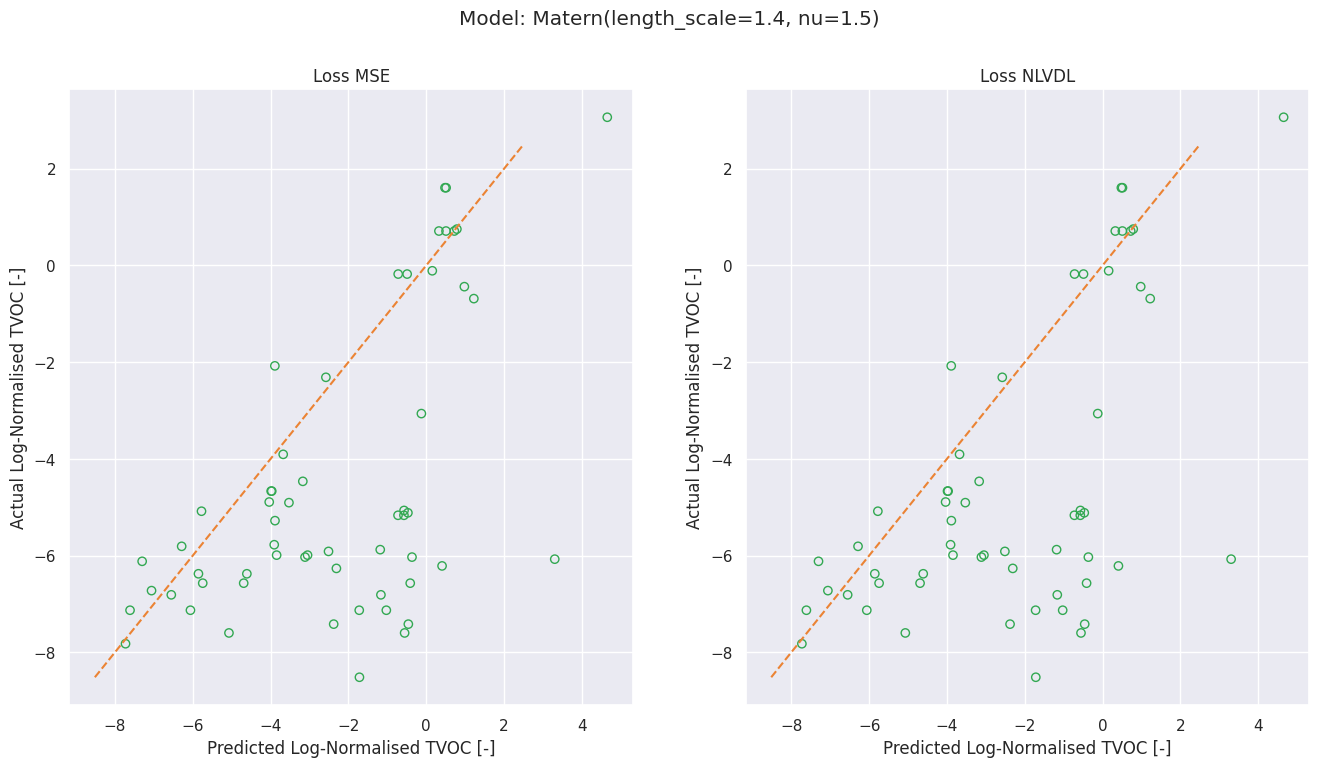

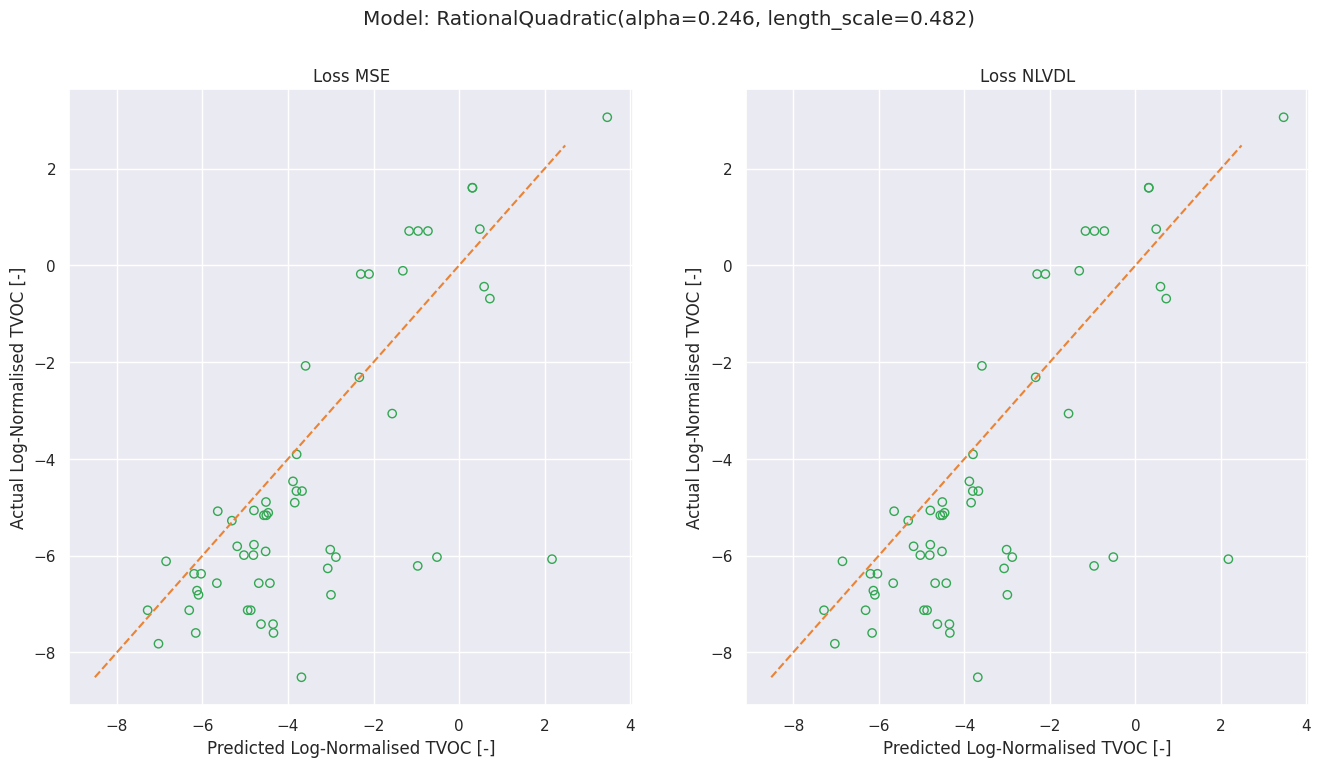

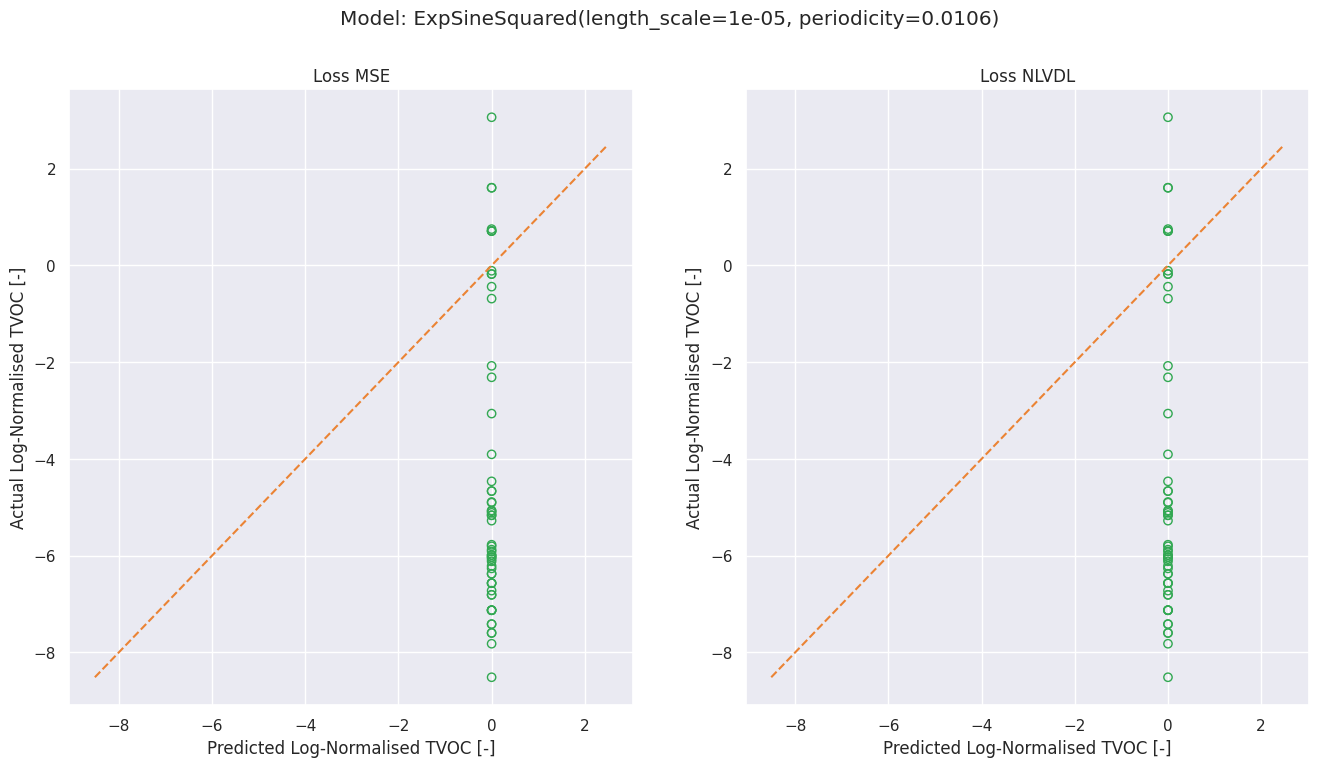

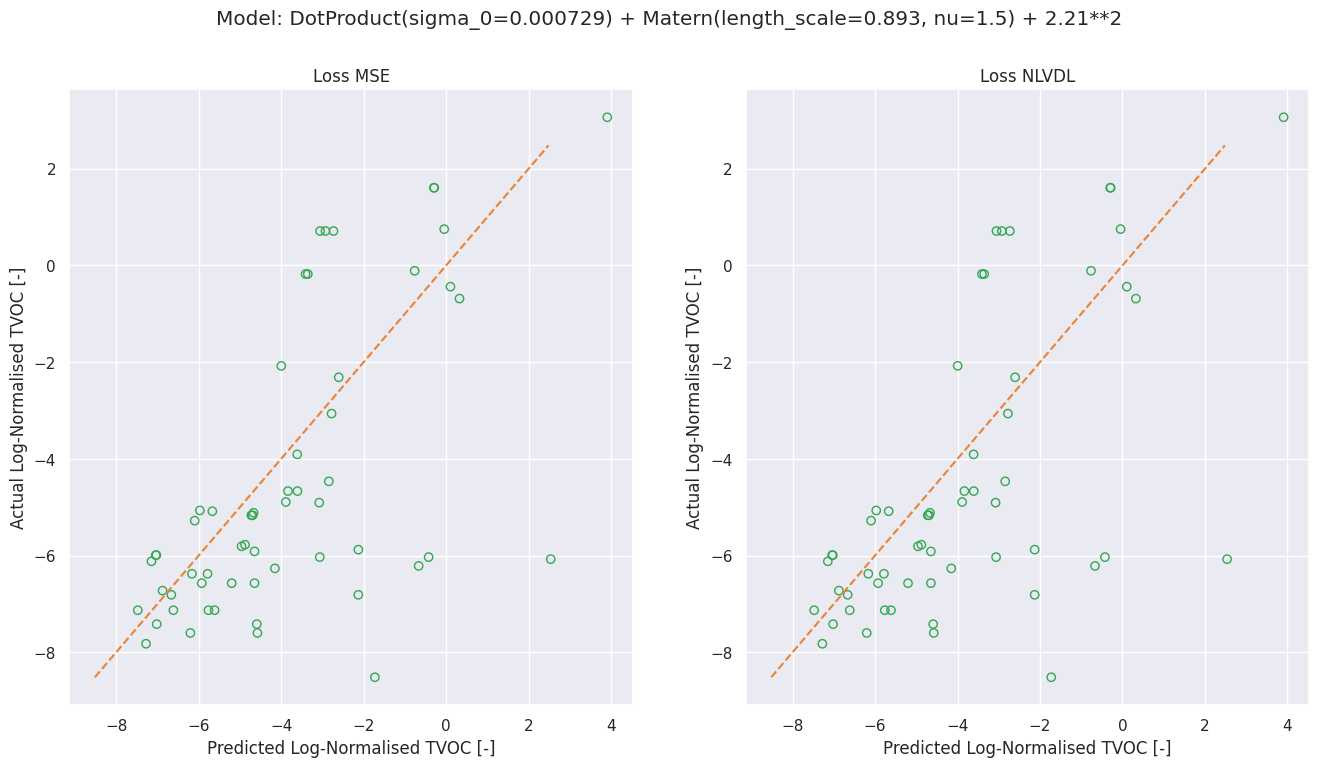

In [28]:
# Get predicted values for MSE and NLVDL
y_preds_mse, y_preds_nlvdl = test_kernels()

# Iterate over best models for NLVDL
for (kernel, info), y_pred_mse, y_pred_nlvdl in zip(best_models_nlvdl.items(), y_preds_mse, y_preds_nlvdl):
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Create a reference line for comparison
    reference_line = np.arange(np.min(y_test), np.max(y_test))

    # Scatter plot for MSE predictions
    axs[0].scatter(y_pred_mse, y_test, facecolors='none', edgecolors='#32a852', marker='o')
    axs[0].plot(reference_line, reference_line, color='#eb8334', linestyle='--')  # Reference line
    axs[0].set_xlabel('Predicted Log-Normalised TVOC [-]')
    axs[0].set_ylabel('Actual Log-Normalised TVOC [-]')
    axs[0].set_title('Loss MSE')

    # Scatter plot for NLVDL predictions
    axs[1].scatter(y_pred_nlvdl, y_test, facecolors='none', edgecolors='#32a852', marker='o')
    axs[1].plot(reference_line, reference_line, color='#eb8334', linestyle='--')  # Reference line
    axs[1].set_xlabel('Predicted Log-Normalised TVOC [-]')
    axs[1].set_ylabel('Actual Log-Normalised TVOC [-]')
    axs[1].set_title('Loss NLVDL')

    fig.suptitle(f'Model: {info["model"].kernel_}')

    plt.show()
    plt.close(fig);

In [29]:
# Bij de laatste stukken van het notebook nog text and uitleg geven 
# Slides

<p style="text-align: justify; overflow-x:hidden;">This notebook is made by: Julian Biesheuvel, Khalid Rovio, Anne van der Pauw, and Stevin van Brussel. Supervisor: Guillaume Rongier. This notebook, is part of a larger assignment for the course Data Science and Artificial Intelligence for Engineering (DSAIE, CEG2003), as part of the Master Applied Earth Science and Civil Engineering at the Delft University of Technology. Date, February 2, 2024.</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=43f1d11b-db76-4626-91af-712e5d84d518' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>